In [1]:
# -*- coding: utf-8 -*-
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns #visualisation
%load_ext autoreload
%autoreload 2

In [2]:
from implementations import *
from helpers_perso import *
from plots import *
from proj1_helpers import *
from zipfile import ZipFile

## Loading the data

In [3]:
# Train set
DATA_TRAIN_PATH = '../data/train.csv' # TODO: download train data and supply path here 
with ZipFile('../data/train.csv.zip', 'r') as zip:
    zip.extractall('../data')
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)
print("Size of the training set: {}.".format(tX.shape[0]))
# Test set
DATA_TEST_PATH = '../data/test.csv' # TODO: download train data and supply path here 
with ZipFile('../data/test.csv.zip', 'r') as zip:
    zip.extractall('../data')
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)
print("Size of the test set: {}.".format(tX_test.shape[0]))

Size of the training set: 250000.
Size of the test set: 568238.


## Exploring the data

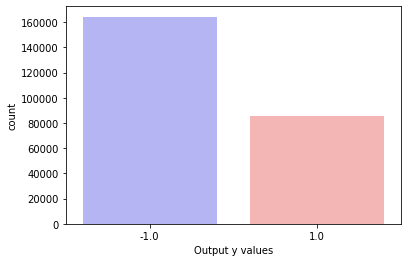

In [4]:
#Exploring y
sns.countplot(x = y, palette = "bwr") 
plt.xlabel("Output y values")
plt.show()

The prediction values are -1 and 1. As our code implementation (specially the loss for the regression) is for 0 and 1 we change these.

In [5]:
# Binary problem change the labels in y 
print("Example", y[0:10])
y = np.where(y == -1, 0, y)
print("Example after", y[0:10])

Example [ 1. -1. -1. -1. -1. -1.  1.  1. -1.  1.]
Example after [1. 0. 0. 0. 0. 0. 1. 1. 0. 1.]


In [6]:
tX.shape[1]

30

There are 30 features

In [7]:
tX[0:3]

array([[ 1.38470e+02,  5.16550e+01,  9.78270e+01,  2.79800e+01,
         9.10000e-01,  1.24711e+02,  2.66600e+00,  3.06400e+00,
         4.19280e+01,  1.97760e+02,  1.58200e+00,  1.39600e+00,
         2.00000e-01,  3.26380e+01,  1.01700e+00,  3.81000e-01,
         5.16260e+01,  2.27300e+00, -2.41400e+00,  1.68240e+01,
        -2.77000e-01,  2.58733e+02,  2.00000e+00,  6.74350e+01,
         2.15000e+00,  4.44000e-01,  4.60620e+01,  1.24000e+00,
        -2.47500e+00,  1.13497e+02],
       [ 1.60937e+02,  6.87680e+01,  1.03235e+02,  4.81460e+01,
        -9.99000e+02, -9.99000e+02, -9.99000e+02,  3.47300e+00,
         2.07800e+00,  1.25157e+02,  8.79000e-01,  1.41400e+00,
        -9.99000e+02,  4.20140e+01,  2.03900e+00, -3.01100e+00,
         3.69180e+01,  5.01000e-01,  1.03000e-01,  4.47040e+01,
        -1.91600e+00,  1.64546e+02,  1.00000e+00,  4.62260e+01,
         7.25000e-01,  1.15800e+00, -9.99000e+02, -9.99000e+02,
        -9.99000e+02,  4.62260e+01],
       [-9.99000e+02,  1.62172

A quick look in the data reveils there a many -999 values. The datasheet tells us that these are invalid values. 

Set them to NaN

In [8]:
for t_set in [tX, tX_test]:
    t_set[t_set == -999] = np.nan

In [9]:
tX[3]

array([ 1.43905e+02,  8.14170e+01,  8.09430e+01,  4.14000e-01,
                nan,          nan,          nan,  3.31000e+00,
        4.14000e-01,  7.59680e+01,  2.35400e+00, -1.28500e+00,
                nan,  2.26470e+01, -1.65500e+00,  1.00000e-02,
        5.33210e+01, -5.22000e-01, -3.10000e+00,  3.10820e+01,
        6.00000e-02,  8.60620e+01,  0.00000e+00,          nan,
                nan,          nan,          nan,          nan,
                nan,  0.00000e+00])

We successfully replaced all the invalid data.

### Visualisation of the data: checking the distribution

c:\users\ojkbe\desktop\master\semp\studium\machine learning\pyth\ml\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


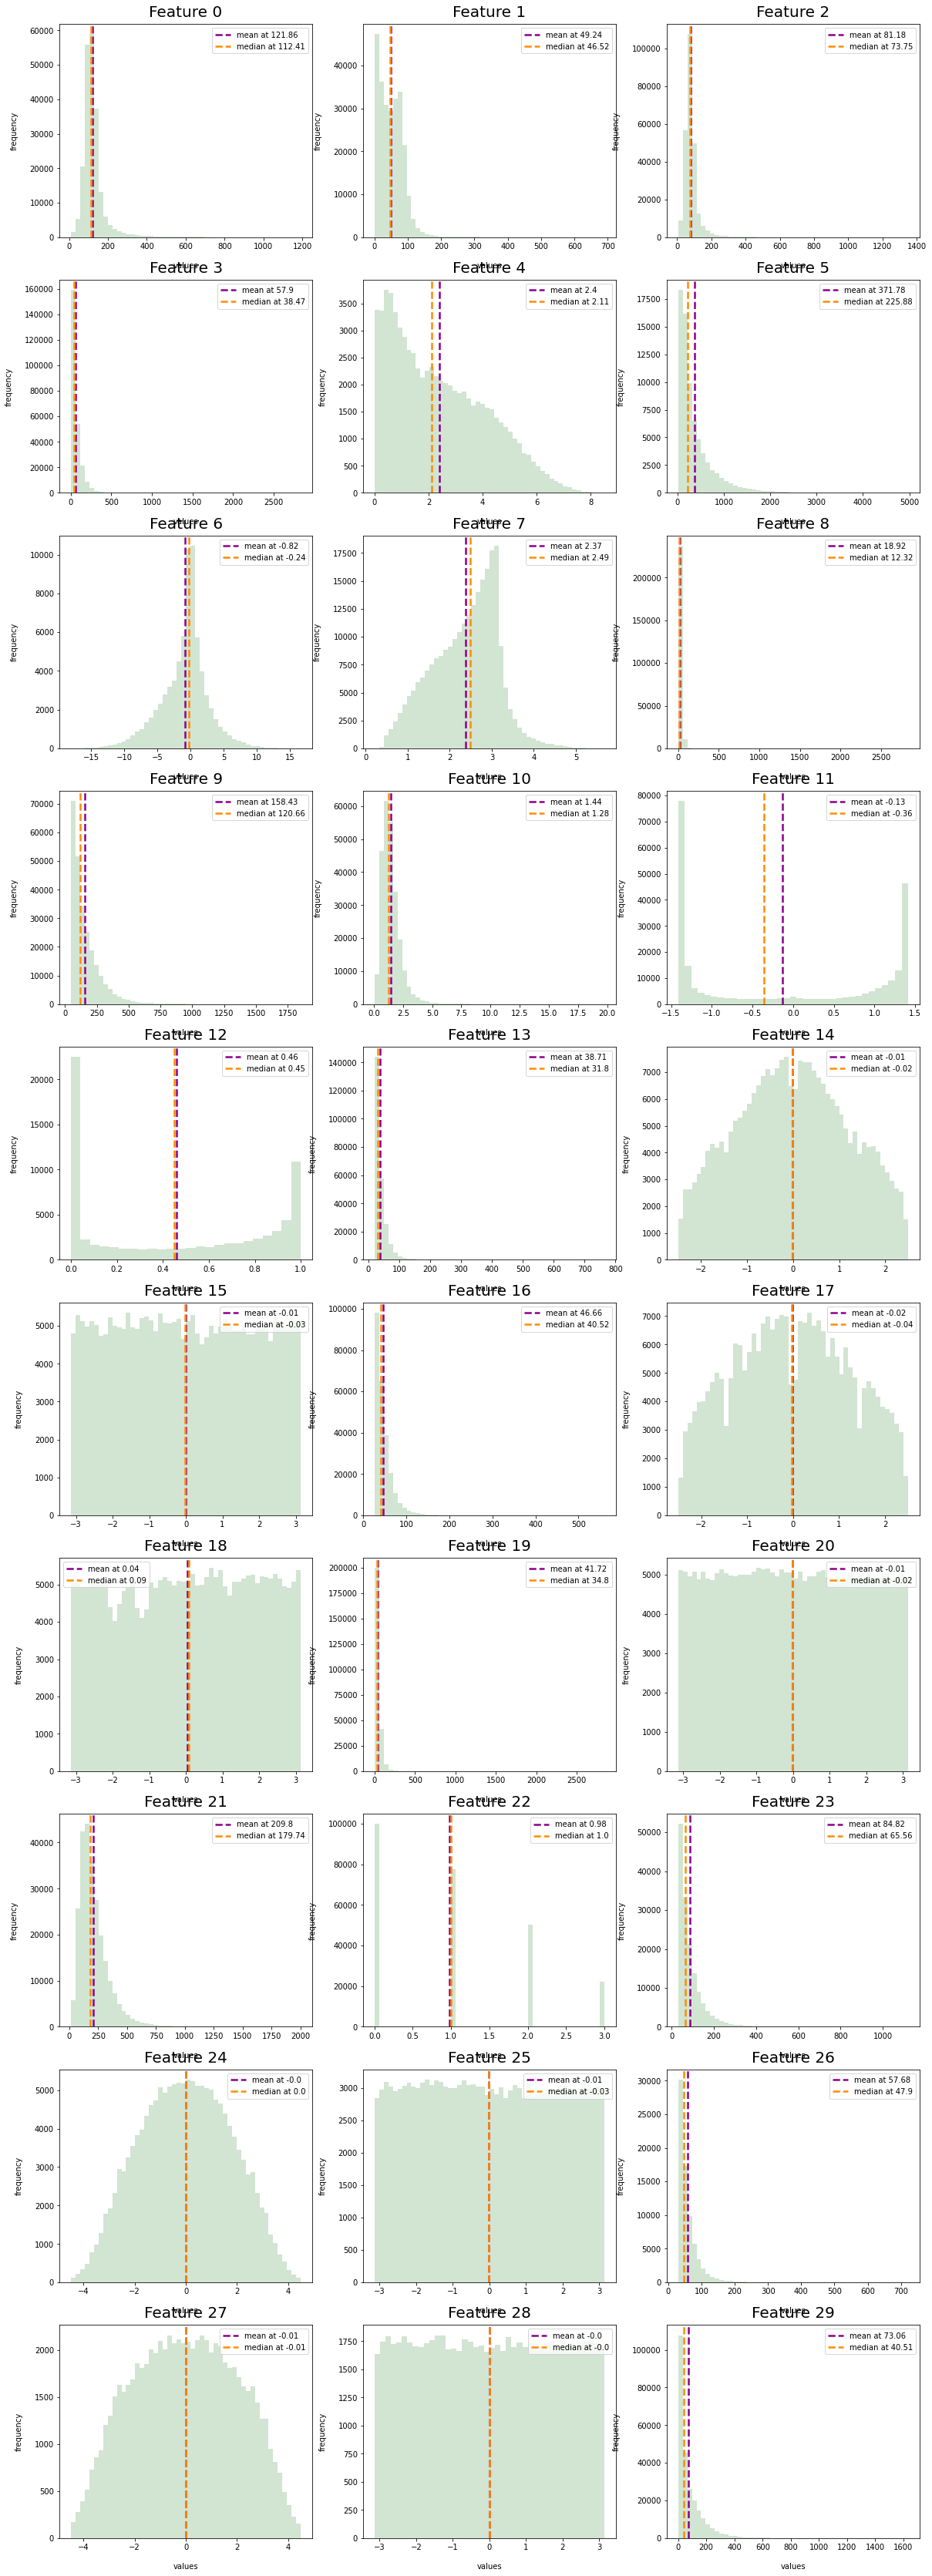

In [10]:
fig = plt.figure()
number_features = tX.shape[1]
for i in range(0, number_features):
    ax = fig.add_subplot(10, 3, i+1)
    plt.xlabel("values", labelpad=15)
    plt.ylabel("frequency", labelpad=15)
    mean = round(np.nanmean(tX[:, i], axis=0), 2)
    median = round(np.nanmedian(tX[:, i], axis=0), 2)
    plt.title("Feature {}".format(i), fontsize=20, y=1.012)
    ax = sns.distplot(tX[:, i], kde=False, color='darkseagreen')
    plt.axvline(x=mean, linestyle='--', linewidth=2.5, label='{0} at {1}'.format("mean", mean), c='darkmagenta')
    plt.axvline(x=median, linestyle='--', linewidth=2.5, label='{0} at {1}'.format("median", median), c='darkorange')
    plt.legend()
fig.set_size_inches(20, 60)

These features are skewed:
0,1,2,3,4,5,7,8,9,10,11,12,13,16,19,21,23,26,29
Feature 22 is categorical

## Standardisation

Log-normalize the skewed indexes

In [11]:
log_norm_idx = [0,1,2,3,4,5,7,8,9,10,13,16,19,21,23,26,29]
for t_set in [tX, tX_test]:
    t_set[:, log_norm_idx] = np.log1p(t_set[:, log_norm_idx])

Standardisation

In [12]:
tX, mean_X_train, std_X_train = standardize(tX)
tX_test, mean_X_test, std_X_test = standardize(tX_test, mean_X_train, std_X_train)

Remove every NaN with the mean.
After standardisation the mean is 0. So NaN = 0.

In [13]:
for t_set in [tX, tX_test]:
    t_set[np.ma.masked_invalid(t_set).mask] = 0

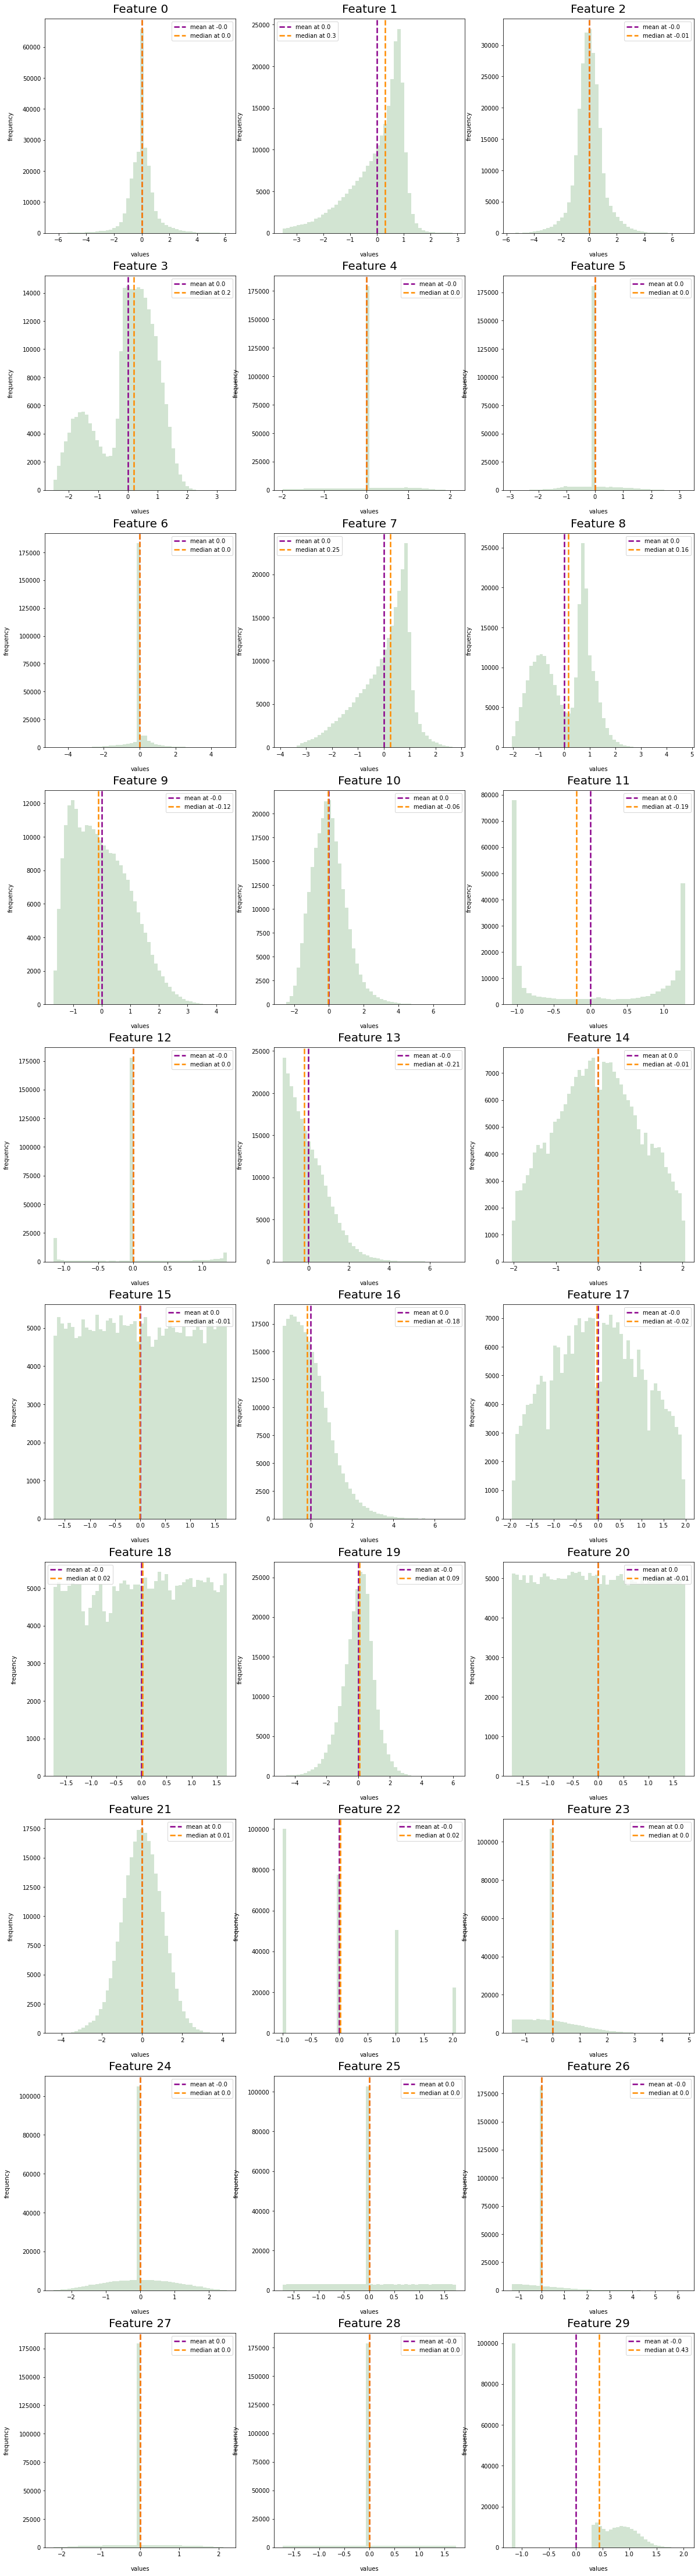

In [14]:
fig = plt.figure()
number_features = tX.shape[1]
for i in range(0, number_features):
    ax = fig.add_subplot(10, 3, i+1)
    plt.xlabel("values", labelpad=15)
    plt.ylabel("frequency", labelpad=15)
    mean = round(np.nanmean(tX[:, i], axis=0), 2)
    median = round(np.nanmedian(tX[:, i], axis=0), 2)
    plt.title("Feature {}".format(i), fontsize=20, y=1.012)
    ax = sns.distplot(tX[:, i], kde=False, color='darkseagreen')
    plt.axvline(x=mean, linestyle='--', linewidth=2.5, label='{0} at {1}'.format("mean", mean), c='darkmagenta')
    plt.axvline(x=median, linestyle='--', linewidth=2.5, label='{0} at {1}'.format("median", median), c='darkorange')
    plt.legend()
fig.set_size_inches(20, 80)

The mean and the standard deviation is now 0 and 1 for every feature.

### Create Train, Validate and a Test Set

In [15]:
# from train take 20% as a validation set and 20% as a test set
tX_train, tX_val, y_train, y_val = split_data(tX, y, ratio=0.8, seed=1)
print("Size of the train set: {}. Size of the validation set: {}.".format(tX_train.shape[0], tX_val.shape[0]))

Size of the train set: 200000. Size of the validation set: 50000.


## First Taining: Getting a Baseline

### least_squares_GD and compute_loss_mse

In: Degree 1, Gamma 0.001, Lambda None


In step: 100%|███████████████████████████████| 200/200 [00:03<00:00, 50.35it/s]


In run: 0, trained. Train loss: 0.15710592605999907, Val loss: 0.15806615657263962.


In step: 100%|███████████████████████████████| 200/200 [00:03<00:00, 50.92it/s]


In run: 1, trained. Train loss: 0.15186144009816474, Val loss: 0.15282636584486495.


In step: 100%|███████████████████████████████| 200/200 [00:03<00:00, 50.38it/s]


In run: 2, trained. Train loss: 0.14939449802620555, Val loss: 0.15036416033542938.


In step: 100%|███████████████████████████████| 200/200 [00:04<00:00, 49.45it/s]


In run: 3, trained. Train loss: 0.14809339157088502, Val loss: 0.14906553717981222.


In step: 100%|███████████████████████████████| 200/200 [00:03<00:00, 50.89it/s]


In run: 4, trained. Train loss: 0.14734959829580466, Val loss: 0.14832217742222178.
Best weights from iteration 1000
TP: 255, TN: 32716, FP: 54, FN: 16975


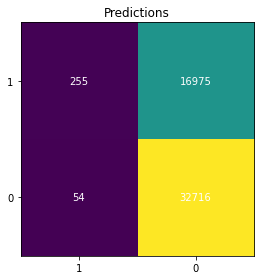

Recall: 0.014799767846778875
Precision: 0.8252427184466019
F_2 score: 0.018417137326842796
Accruacy: 0.65942
----------------------------------------------------------------------------------------------------
In: Degree 3, Gamma 0.001, Lambda None


In step: 100%|███████████████████████████████| 200/200 [00:09<00:00, 20.59it/s]


In run: 0, trained. Train loss: 0.09225788749310466, Val loss: 0.09269116721535864.


In step: 100%|███████████████████████████████| 200/200 [00:09<00:00, 21.45it/s]


In run: 1, trained. Train loss: 0.08642971911987143, Val loss: 0.08682182678090611.


In step: 100%|███████████████████████████████| 200/200 [00:09<00:00, 21.25it/s]


In run: 2, trained. Train loss: 0.08397956910889659, Val loss: 0.08429971444078965.


In step: 100%|███████████████████████████████| 200/200 [00:09<00:00, 21.37it/s]


In run: 3, trained. Train loss: 0.08249628165507322, Val loss: 0.08275671173738278.


In step: 100%|███████████████████████████████| 200/200 [00:09<00:00, 22.07it/s]


In run: 4, trained. Train loss: 0.08148131267837422, Val loss: 0.08169509670473624.
Best weights from iteration 1000
TP: 8048, TN: 29811, FP: 2959, FN: 9182


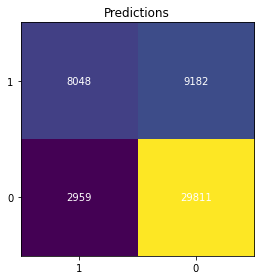

Recall: 0.46709228090539756
Precision: 0.731171072953575
F_2 score: 0.5034594067086217
Accruacy: 0.75718
----------------------------------------------------------------------------------------------------


In [16]:
val_iter, max_iter = 200, 1000
degrees, gammas, lambdas_ = [1, 3], [0.001], [None]
method_train, method_loss = least_squares_GD, compute_loss_mse
grid_search(y_val, tX_val, val_iter, method_train, method_loss, y, tX, max_iter, degrees, gammas, lambdas_)

Grid search with trainer_val picks the best validated weights.
Below shows code of the training of degree = 0 without the grid search or trainer_val.

In step: 100%|█████████████████████████████| 1000/1000 [00:12<00:00, 77.52it/s]


TP: 828, TN: 32599, FP: 171, FN: 16402


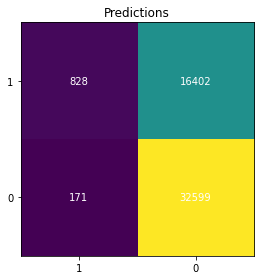

Recall: 0.048055716773070224
Precision: 0.8288288288288288
F_2 score: 0.05921137316037128
Accruacy: 0.66854
MSE loss 0.1442735652924395
Prediction example [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [17]:
# Training on the learning dataset
train_loss, weights = least_squares_GD(y_train, tX_train, initial_w=np.zeros(tX_train.shape[1]), max_iters=1000, gamma=0.1)
# Estimating the predictions on the validation set
# pred_val = tX_val@weights
pred_val = predict_labels(weights, tX_val)
# Confusion matrix
tp, tn, fp, fn = calc_rates(y_val, pred_val)
vis_conf_mtx(conf_matrix(tp, tn, fp, fn))
# Recall, Precision, F2-Score, Accruacy
f_score(recall(tp, fn), precision(tp, fp))
accruacy(tp, tn, fp, fn)
# Computing the mse resulting from the validation set
### odd: just predicted now again
mse_test = compute_loss_mse(y_val, tX_val, weights)
print("MSE loss", mse_test)
print("Prediction example", pred_val[:10])

## least_squares_SGD and compute_loss_mse

In: Degree 1, Gamma 0.01, Lambda None


100%|█████████████████████████████████████| 200/200 [00:00<00:00, 25126.88it/s]


In run: 0, trained. Train loss: 0.16585367833514617, Val loss: 0.16642661123708385.


100%|█████████████████████████████████████| 200/200 [00:00<00:00, 25006.28it/s]


In run: 1, trained. Train loss: 0.16129639447291025, Val loss: 0.16257578903468398.


100%|█████████████████████████████████████| 200/200 [00:00<00:00, 25015.23it/s]


In run: 2, trained. Train loss: 0.16514369367029616, Val loss: 0.1657661581501651.


100%|█████████████████████████████████████| 200/200 [00:00<00:00, 25015.98it/s]


In run: 3, trained. Train loss: 0.16308702816255857, Val loss: 0.16447389894306302.


100%|█████████████████████████████████████| 200/200 [00:00<00:00, 25000.32it/s]

In run: 4, trained. Train loss: 0.16452714664606563, Val loss: 0.16513907863717725.
Best weights from iteration 400


TP: 2100, TN: 31833, FP: 937, FN: 15130


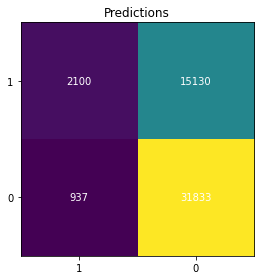

Recall: 0.12188044109112015
Precision: 0.691471847217649
F_2 score: 0.145920480286838
Accruacy: 0.67866
----------------------------------------------------------------------------------------------------
In: Degree 3, Gamma 0.01, Lambda None


100%|█████████████████████████████████████| 200/200 [00:00<00:00, 25181.18it/s]


In run: 0, trained. Train loss: 3.520284188430981e+20, Val loss: 3.4727905947799585e+20.


100%|█████████████████████████████████████| 200/200 [00:00<00:00, 25011.50it/s]


In run: 1, trained. Train loss: 2.759283010253398e+34, Val loss: 2.839028375076828e+34.


100%|█████████████████████████████████████| 200/200 [00:00<00:00, 25001.07it/s]


In run: 2, trained. Train loss: 2.8748542941803344e+63, Val loss: 2.8153758401362562e+63.


100%|█████████████████████████████████████| 200/200 [00:00<00:00, 25008.52it/s]


In run: 3, trained. Train loss: 6.779023807541623e+99, Val loss: 6.523014521054253e+99.


100%|█████████████████████████████████████| 200/200 [00:00<00:00, 25030.91it/s]


In run: 4, trained. Train loss: 1.702118439610958e+123, Val loss: 1.6947374184591118e+123.
Best weights from iteration 200
TP: 12458, TN: 12469, FP: 20301, FN: 4772


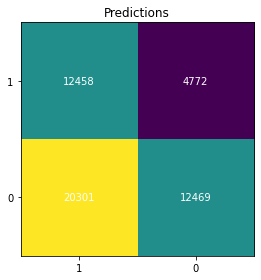

Recall: 0.7230412071967498
Precision: 0.3802924387191306
F_2 score: 0.6126142074568003
Accruacy: 0.49854
----------------------------------------------------------------------------------------------------
In: Degree 5, Gamma 0.01, Lambda None


100%|█████████████████████████████████████| 200/200 [00:00<00:00, 24895.71it/s]


In run: 0, trained. Train loss: 4.616770644396766e+192, Val loss: 4.326190469869187e+192.


100%|█████████████████████████████████████| 200/200 [00:00<00:00, 16651.66it/s]
C:\Users\ojkbe\Desktop\Master\SEMP\Studium\Machine Learning\pyth\ml-project-1-mgo\project1\scripts\implementations.py:16: RuntimeWarning: overflow encountered in square
  return 1/2*np.mean(e**2)


In run: 1, trained. Train loss: inf, Val loss: inf.


100%|█████████████████████████████████████| 200/200 [00:00<00:00, 24992.87it/s]


In run: 2, trained. Train loss: inf, Val loss: inf.


100%|█████████████████████████████████████| 200/200 [00:00<00:00, 24892.01it/s]


In run: 3, trained. Train loss: nan, Val loss: nan.


100%|█████████████████████████████████████| 200/200 [00:00<00:00, 16670.52it/s]


In run: 4, trained. Train loss: nan, Val loss: nan.
Best weights from iteration 200
TP: 5127, TN: 17713, FP: 15057, FN: 12103


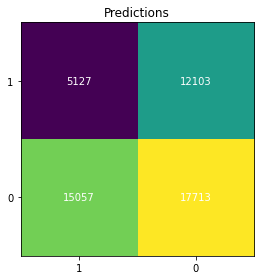

Recall: 0.2975623911781776
Precision: 0.25401307966706305
F_2 score: 0.28769752199676785
Accruacy: 0.4568
----------------------------------------------------------------------------------------------------


In [18]:
val_iter, max_iter = 200, 1000
degrees, gammas, lambdas_ = [1, 3, 5], [0.01], [None]
method_train, method_loss = least_squares_SGD, compute_loss_mse
grid_search(y_val, tX_val, val_iter, method_train, method_loss, y, tX, max_iter, degrees, gammas, lambdas_)

## Least Squares and compute_loss_mse

In: Degree 1, Gamma None, Lambda None
In run: 0, trained. Train loss: 0.14316277008157074, Val loss: 0.1442638224554747.
Best weights from iteration 1
TP: 849, TN: 32585, FP: 185, FN: 16381


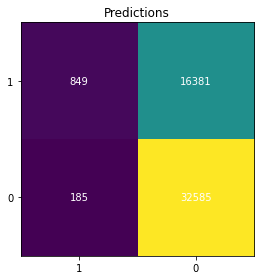

Recall: 0.04927452118398143
Precision: 0.8210831721470019
F_2 score: 0.06068273436829917
Accruacy: 0.66868
----------------------------------------------------------------------------------------------------
In: Degree 2, Gamma None, Lambda None
In run: 0, trained. Train loss: 0.07673090157827427, Val loss: 0.07700702817832901.
Best weights from iteration 1
TP: 10423, TN: 28736, FP: 4034, FN: 6807


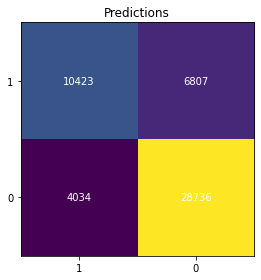

Recall: 0.6049332559489263
Precision: 0.7209656221899425
F_2 score: 0.6250524725044077
Accruacy: 0.78318
----------------------------------------------------------------------------------------------------
In: Degree 3, Gamma None, Lambda None
In run: 0, trained. Train loss: 0.0750480619059265, Val loss: 0.07538858902118337.
Best weights from iteration 1
TP: 10675, TN: 28895, FP: 3875, FN: 6555


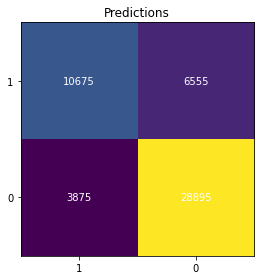

Recall: 0.6195589088798608
Precision: 0.7336769759450171
F_2 score: 0.6394512998682161
Accruacy: 0.7914
----------------------------------------------------------------------------------------------------
In: Degree 5, Gamma None, Lambda None
In run: 0, trained. Train loss: 0.0715447493297398, Val loss: 0.0717326032151584.
Best weights from iteration 1
TP: 11341, TN: 28996, FP: 3774, FN: 5889


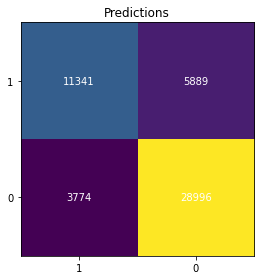

Recall: 0.6582124201973303
Precision: 0.7503142573602382
F_2 score: 0.6747783661569585
Accruacy: 0.80674
----------------------------------------------------------------------------------------------------
In: Degree 7, Gamma None, Lambda None
In run: 0, trained. Train loss: 0.06930051083975906, Val loss: 0.06963378355142773.
Best weights from iteration 1
TP: 11671, TN: 29009, FP: 3761, FN: 5559


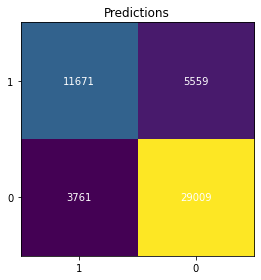

Recall: 0.6773650609402205
Precision: 0.7562856402280974
F_2 score: 0.6918033952959028
Accruacy: 0.8136
----------------------------------------------------------------------------------------------------


In [19]:
degrees, gammas, lambdas_ = [1, 2, 3, 5, 7], [None], [None]
# only 1 iterations as there are no steps
max_iter, val_iter = 1, 1
method_train, method_loss = least_squares, compute_loss_mse
grid_search(y_val, tX_val, val_iter, method_train, method_loss, y_train, tX_train, max_iter, degrees, gammas, lambdas_)

TP: 10675, TN: 28895, FP: 3875, FN: 6555


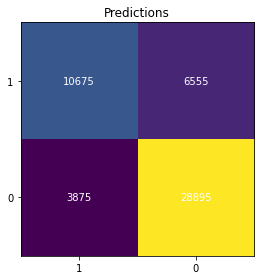

Recall: 0.6195589088798608
Precision: 0.7336769759450171
F_2 score: 0.6394512998682161
Accruacy: 0.7914
MSE loss 0.07538858902118337
Prediction example [0. 0. 0. 0. 0. 0. 1. 0. 1. 0.]


In [20]:
# Training on the learning dataset
tX_val_p = buildpoly(tX_val, 3)
tX_train_p = buildpoly(tX_train, 3)
train_loss, weights = least_squares(y_train, tX_train_p)
# Estimating the predictions on the validation set
# pred_val = tX_val@weights
pred_val = predict_labels(weights, tX_val_p) 
# Confusion matrix
tp, tn, fp, fn = calc_rates(y_val, pred_val)
vis_conf_mtx(conf_matrix(tp, tn, fp, fn))
# Recall, Precision, F2-Score, Accruacy
f_score(recall(tp, fn), precision(tp, fp))
accruacy(tp, tn, fp, fn)
# Computing the mse resulting from the validation set
### odd: just predicted now again
mse_test = compute_loss_mse(y_val, tX_val_p, weights)
print("MSE loss", mse_test)
print("Prediction example", pred_val[:10])

## Ridge regression and compute_loss_mse

In: Degree 1, Gamma None, Lambda 0
In run: 0, trained. Train loss: 0.14316277008157074, Val loss: 0.1442638224554747.
Best weights from iteration 1
TP: 849, TN: 32585, FP: 185, FN: 16381


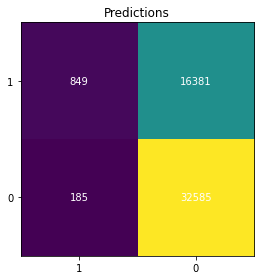

Recall: 0.04927452118398143
Precision: 0.8210831721470019
F_2 score: 0.06068273436829917
Accruacy: 0.66868
----------------------------------------------------------------------------------------------------
In: Degree 1, Gamma None, Lambda 0.5
In run: 0, trained. Train loss: 0.1491352284929347, Val loss: 0.15036629043189234.
Best weights from iteration 1
TP: 29, TN: 32764, FP: 6, FN: 17201


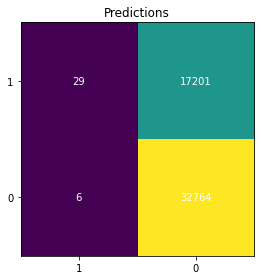

Recall: 0.0016831108531630877
Precision: 0.8285714285714286
F_2 score: 0.0021028206801537237
Accruacy: 0.65586
----------------------------------------------------------------------------------------------------
In: Degree 1, Gamma None, Lambda 0.1
In run: 0, trained. Train loss: 0.14536666823419375, Val loss: 0.14655909527387115.
Best weights from iteration 1
TP: 446, TN: 32690, FP: 80, FN: 16784


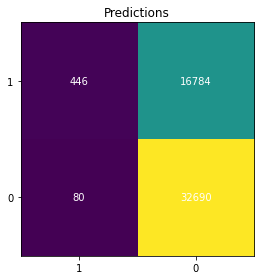

Recall: 0.025885084155542658
Precision: 0.8479087452471483
F_2 score: 0.03211128070731216
Accruacy: 0.66272
----------------------------------------------------------------------------------------------------
In: Degree 1, Gamma None, Lambda 0.01
In run: 0, trained. Train loss: 0.1434344578822173, Val loss: 0.14454031602896353.
Best weights from iteration 1
TP: 769, TN: 32613, FP: 157, FN: 16461


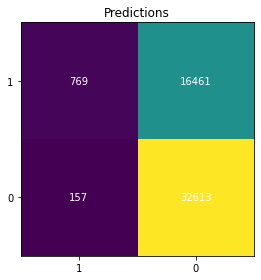

Recall: 0.044631456761462567
Precision: 0.8304535637149028
F_2 score: 0.055049680726169004
Accruacy: 0.66764
----------------------------------------------------------------------------------------------------
In: Degree 2, Gamma None, Lambda 0
In run: 0, trained. Train loss: 0.07673090157827427, Val loss: 0.07700702817832901.
Best weights from iteration 1
TP: 10423, TN: 28736, FP: 4034, FN: 6807


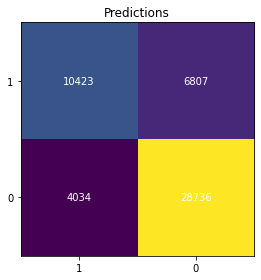

Recall: 0.6049332559489263
Precision: 0.7209656221899425
F_2 score: 0.6250524725044077
Accruacy: 0.78318
----------------------------------------------------------------------------------------------------
In: Degree 2, Gamma None, Lambda 0.5
In run: 0, trained. Train loss: 0.08598721660464444, Val loss: 0.08631381352987477.
Best weights from iteration 1
TP: 5604, TN: 30761, FP: 2009, FN: 11626


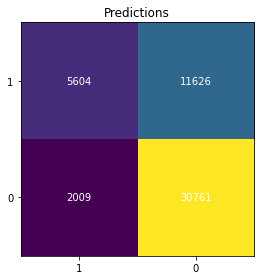

Recall: 0.3252466627974463
Precision: 0.7361092867463549
F_2 score: 0.3661165771627925
Accruacy: 0.7273
----------------------------------------------------------------------------------------------------
In: Degree 2, Gamma None, Lambda 0.1
In run: 0, trained. Train loss: 0.08003050986834714, Val loss: 0.08025494063212767.
Best weights from iteration 1
TP: 8534, TN: 29733, FP: 3037, FN: 8696


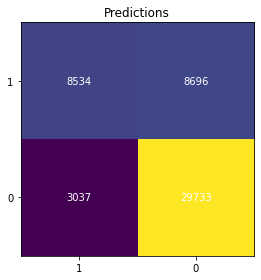

Recall: 0.49529889727219967
Precision: 0.7375334888946504
F_2 score: 0.5301213800300655
Accruacy: 0.76534
----------------------------------------------------------------------------------------------------
In: Degree 2, Gamma None, Lambda 0.01
In run: 0, trained. Train loss: 0.07726900545176928, Val loss: 0.07749991109793342.
Best weights from iteration 1
TP: 10064, TN: 29051, FP: 3719, FN: 7166


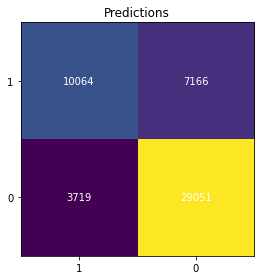

Recall: 0.5840975043528729
Precision: 0.7301748530798811
F_2 score: 0.6084422572337158
Accruacy: 0.7823
----------------------------------------------------------------------------------------------------
In: Degree 3, Gamma None, Lambda 0
In run: 0, trained. Train loss: 0.0750480619059265, Val loss: 0.07538858902118337.
Best weights from iteration 1
TP: 10675, TN: 28895, FP: 3875, FN: 6555


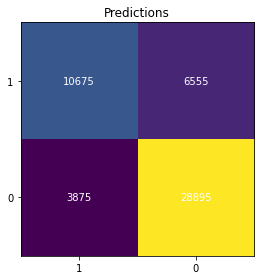

Recall: 0.6195589088798608
Precision: 0.7336769759450171
F_2 score: 0.6394512998682161
Accruacy: 0.7914
----------------------------------------------------------------------------------------------------
In: Degree 3, Gamma None, Lambda 0.5
In run: 0, trained. Train loss: 0.08366780093653008, Val loss: 0.08407322520632664.
Best weights from iteration 1
TP: 6215, TN: 30685, FP: 2085, FN: 11015


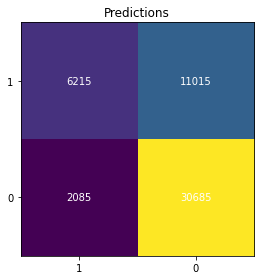

Recall: 0.3607080673244341
Precision: 0.7487951807228915
F_2 score: 0.4024216524216524
Accruacy: 0.738
----------------------------------------------------------------------------------------------------
In: Degree 3, Gamma None, Lambda 0.1
In run: 0, trained. Train loss: 0.07827671951036796, Val loss: 0.07849981530743413.
Best weights from iteration 1
TP: 9014, TN: 29728, FP: 3042, FN: 8216


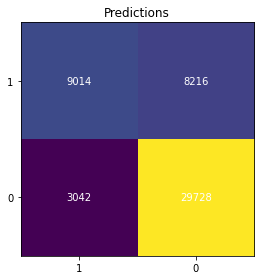

Recall: 0.5231572838073129
Precision: 0.7476775049767751
F_2 score: 0.5565846670618456
Accruacy: 0.77484
----------------------------------------------------------------------------------------------------
In: Degree 3, Gamma None, Lambda 0.01
In run: 0, trained. Train loss: 0.07569720095221734, Val loss: 0.07596378040125663.
Best weights from iteration 1
TP: 10280, TN: 29135, FP: 3635, FN: 6950


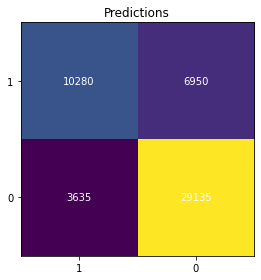

Recall: 0.5966337782936738
Precision: 0.7387711103126123
F_2 score: 0.6205106537091809
Accruacy: 0.7883
----------------------------------------------------------------------------------------------------
In: Degree 5, Gamma None, Lambda 0
In run: 0, trained. Train loss: 0.0715447493297398, Val loss: 0.0717326032151584.
Best weights from iteration 1
TP: 11341, TN: 28996, FP: 3774, FN: 5889


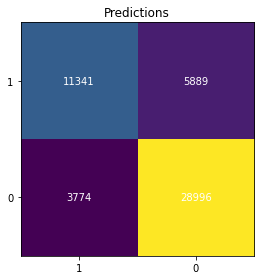

Recall: 0.6582124201973303
Precision: 0.7503142573602382
F_2 score: 0.6747783661569585
Accruacy: 0.80674
----------------------------------------------------------------------------------------------------
In: Degree 5, Gamma None, Lambda 0.5
In run: 0, trained. Train loss: 0.08065682154468862, Val loss: 0.08076987841376126.
Best weights from iteration 1
TP: 7572, TN: 30229, FP: 2541, FN: 9658


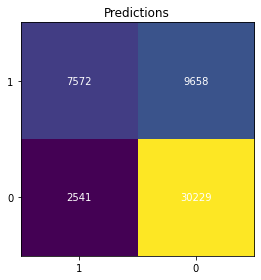

Recall: 0.43946604759141034
Precision: 0.7487392465143874
F_2 score: 0.47904040084521654
Accruacy: 0.75602
----------------------------------------------------------------------------------------------------
In: Degree 5, Gamma None, Lambda 0.1
In run: 0, trained. Train loss: 0.07580686998623475, Val loss: 0.07586317637941299.
Best weights from iteration 1
TP: 9599, TN: 29685, FP: 3085, FN: 7631


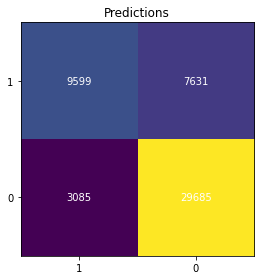

Recall: 0.557109692396982
Precision: 0.7567801955219173
F_2 score: 0.5881451889613255
Accruacy: 0.78568
----------------------------------------------------------------------------------------------------
In: Degree 5, Gamma None, Lambda 0.01
In run: 0, trained. Train loss: 0.07225334780139361, Val loss: 0.072416673368373.
Best weights from iteration 1
TP: 10964, TN: 29191, FP: 3579, FN: 6266


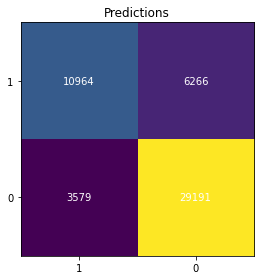

Recall: 0.6363319791062101
Precision: 0.7539022209997938
F_2 score: 0.656817991205684
Accruacy: 0.8031
----------------------------------------------------------------------------------------------------
In: Degree 7, Gamma None, Lambda 0
In run: 0, trained. Train loss: 0.06930051083975906, Val loss: 0.06963378355142773.
Best weights from iteration 1
TP: 11671, TN: 29009, FP: 3761, FN: 5559


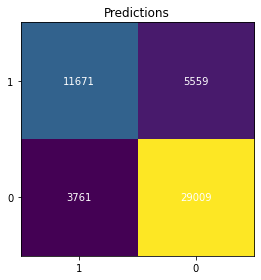

Recall: 0.6773650609402205
Precision: 0.7562856402280974
F_2 score: 0.6918033952959028
Accruacy: 0.8136
----------------------------------------------------------------------------------------------------
In: Degree 7, Gamma None, Lambda 0.5
In run: 0, trained. Train loss: 0.07970355931405407, Val loss: 0.07981063634802346.
Best weights from iteration 1
TP: 7989, TN: 30133, FP: 2637, FN: 9241


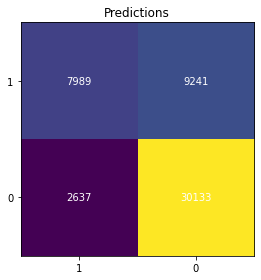

Recall: 0.4636680208937899
Precision: 0.7518351214003388
F_2 score: 0.5021622708872854
Accruacy: 0.76244
----------------------------------------------------------------------------------------------------
In: Degree 7, Gamma None, Lambda 0.1
In run: 0, trained. Train loss: 0.07383334907088182, Val loss: 0.07400055997257031.
Best weights from iteration 1
TP: 9925, TN: 29706, FP: 3064, FN: 7305


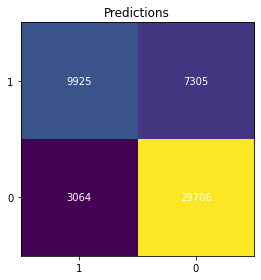

Recall: 0.5760301799187464
Precision: 0.7641080914620063
F_2 score: 0.605855278418733
Accruacy: 0.79262
----------------------------------------------------------------------------------------------------
In: Degree 7, Gamma None, Lambda 0.01
In run: 0, trained. Train loss: 0.07021094306899227, Val loss: 0.07047746069314952.
Best weights from iteration 1
TP: 11279, TN: 29255, FP: 3515, FN: 5951


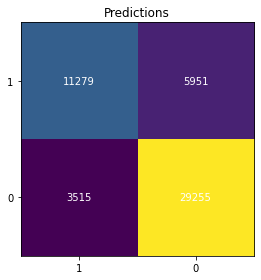

Recall: 0.6546140452698781
Precision: 0.7624036771664188
F_2 score: 0.6736627087464463
Accruacy: 0.81068
----------------------------------------------------------------------------------------------------


In [21]:
# no gamma
degrees, gammas, lambdas_ = [1, 2, 3, 5, 7], [None], [0, 0.5, 0.1, 0.01]
# only 1 iterations as there are no steps
max_iter, val_iter = 1, 1
method_train, method_loss = ridge_regression, compute_loss_mse
grid_search(y_val, tX_val, val_iter, method_train, method_loss, y_train, tX_train, max_iter, degrees, gammas, lambdas_)

## logistic_regression and log loss

In: Degree 1, Gamma 0.001, Lambda None


In step: 100%|███████████████████████████████| 200/200 [00:03<00:00, 51.37it/s]


In run: 0, trained. Train loss: 10078235.413778033, Val loss: 2541848.105624204.


In step: 100%|███████████████████████████████| 200/200 [00:03<00:00, 52.33it/s]


In run: 1, trained. Train loss: 1767502.2724609047, Val loss: 438873.62962788006.


In step: 100%|███████████████████████████████| 200/200 [00:03<00:00, 51.25it/s]


In run: 2, trained. Train loss: 7460607.466430953, Val loss: 1882749.7876017052.


In step: 100%|███████████████████████████████| 200/200 [00:03<00:00, 52.36it/s]


In run: 3, trained. Train loss: 1627072.3219795572, Val loss: 408708.4878118015.


In step: 100%|███████████████████████████████| 200/200 [00:03<00:00, 53.19it/s]


In run: 4, trained. Train loss: 3025691.5147592304, Val loss: 754899.5500737858.
Best weights from iteration 800
TP: 9911, TN: 15800, FP: 16970, FN: 7319


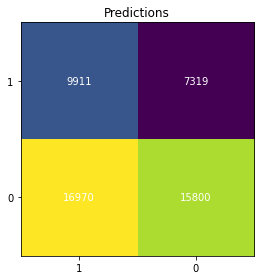

Recall: 0.5752176436448055
Precision: 0.3686990811353744
F_2 score: 0.5172701746328325
Accruacy: 0.51422
----------------------------------------------------------------------------------------------------
In: Degree 3, Gamma 0.001, Lambda None


In step: 100%|███████████████████████████████| 200/200 [00:08<00:00, 22.89it/s]


In run: 0, trained. Train loss: 3204723.7498977706, Val loss: 811581.2510342761.


In step: 100%|███████████████████████████████| 200/200 [00:08<00:00, 22.91it/s]


In run: 1, trained. Train loss: 3207756.0419376977, Val loss: 811169.62947415.


In step: 100%|███████████████████████████████| 200/200 [00:08<00:00, 22.83it/s]


In run: 2, trained. Train loss: 3193538.6556777563, Val loss: 808843.9985345674.


In step: 100%|███████████████████████████████| 200/200 [00:08<00:00, 23.61it/s]


In run: 3, trained. Train loss: 3195563.380784114, Val loss: 807836.4819742902.


In step: 100%|███████████████████████████████| 200/200 [00:08<00:00, 23.62it/s]


In run: 4, trained. Train loss: 3191380.1832593833, Val loss: 806634.9808359193.
Best weights from iteration 1000
TP: 15371, TN: 20672, FP: 12098, FN: 1859


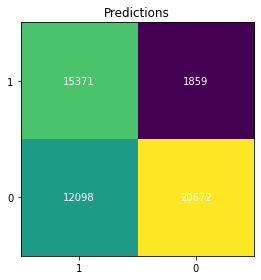

Recall: 0.8921067904817179
Precision: 0.5595762495904474
F_2 score: 0.7973420203550197
Accruacy: 0.72086
----------------------------------------------------------------------------------------------------
In: Degree 5, Gamma 0.001, Lambda None


In step: 100%|███████████████████████████████| 200/200 [00:13<00:00, 15.29it/s]


In run: 0, trained. Train loss: 3207457.1585557833, Val loss: 807554.3472482782.


In step: 100%|███████████████████████████████| 200/200 [00:12<00:00, 15.46it/s]


In run: 1, trained. Train loss: 3233243.6914302385, Val loss: 812634.5941566438.


In step: 100%|███████████████████████████████| 200/200 [00:13<00:00, 14.92it/s]


In run: 2, trained. Train loss: 2802090.8406955176, Val loss: 707775.1999538562.


In step: 100%|███████████████████████████████| 200/200 [00:13<00:00, 15.18it/s]


In run: 3, trained. Train loss: 2687260.8226954713, Val loss: 668783.0355269411.


In step: 100%|███████████████████████████████| 200/200 [00:12<00:00, 15.46it/s]


In run: 4, trained. Train loss: 3528330.963926039, Val loss: 916829.7034785614.
Best weights from iteration 800
TP: 10574, TN: 23462, FP: 9308, FN: 6656


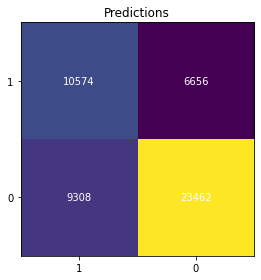

Recall: 0.6136970400464307
Precision: 0.5318378432753245
F_2 score: 0.5953694736605031
Accruacy: 0.68072
----------------------------------------------------------------------------------------------------


In [38]:
degrees, gammas, lambdas_ = [1, 3, 5], [0.001], [None]
max_iter, val_iter = 1000, 200
method_train, method_loss = logistic_regression, calculate_loss
grid_search(y_val, tX_val, val_iter, method_train, method_loss, y_train, tX_train, max_iter, degrees, gammas, lambdas_)

## reg_logistic_regression and log loss

In: Degree 1, Gamma 0.001, Lambda 0


In step: 100%|███████████████████████████████| 200/200 [00:03<00:00, 55.63it/s]


In run: 0, trained. Train loss: 10078235.413778033, Val loss: 2541848.105624204.


In step: 100%|███████████████████████████████| 200/200 [00:03<00:00, 57.34it/s]


In run: 1, trained. Train loss: 1767502.2724609047, Val loss: 438873.62962788006.


In step: 100%|███████████████████████████████| 200/200 [00:03<00:00, 54.53it/s]


In run: 2, trained. Train loss: 7460607.466430953, Val loss: 1882749.7876017052.


In step: 100%|███████████████████████████████| 200/200 [00:03<00:00, 52.25it/s]


In run: 3, trained. Train loss: 1627072.3219795572, Val loss: 408708.4878118015.


In step: 100%|███████████████████████████████| 200/200 [00:03<00:00, 54.64it/s]


In run: 4, trained. Train loss: 3025691.5147592304, Val loss: 754899.5500737858.
Best weights from iteration 800
TP: 9911, TN: 15800, FP: 16970, FN: 7319


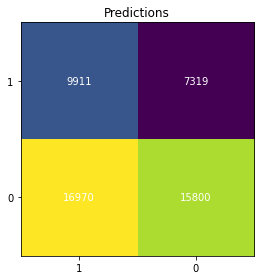

Recall: 0.5752176436448055
Precision: 0.3686990811353744
F_2 score: 0.5172701746328325
Accruacy: 0.51422
----------------------------------------------------------------------------------------------------
In: Degree 1, Gamma 0.001, Lambda 0.1


In step: 100%|███████████████████████████████| 200/200 [00:03<00:00, 53.76it/s]


In run: 0, trained. Train loss: 1588566.7894534608, Val loss: 392938.5601815613.


In step: 100%|███████████████████████████████| 200/200 [00:03<00:00, 55.37it/s]


In run: 1, trained. Train loss: 2541239.7910295436, Val loss: 638309.1622738792.


In step: 100%|███████████████████████████████| 200/200 [00:03<00:00, 56.24it/s]


In run: 2, trained. Train loss: 1804202.9078590393, Val loss: 451786.17995519633.


In step: 100%|███████████████████████████████| 200/200 [00:03<00:00, 54.53it/s]


In run: 3, trained. Train loss: 4400303.644396628, Val loss: 1102020.711794524.


In step: 100%|███████████████████████████████| 200/200 [00:03<00:00, 56.75it/s]


In run: 4, trained. Train loss: 8633753.590584578, Val loss: 2180333.251718818.
Best weights from iteration 200
TP: 11244, TN: 19862, FP: 12908, FN: 5986


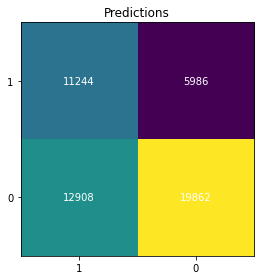

Recall: 0.6525827045850261
Precision: 0.46555150712156346
F_2 score: 0.6040484785972151
Accruacy: 0.62212
----------------------------------------------------------------------------------------------------
In: Degree 1, Gamma 0.001, Lambda 0.01


In step: 100%|███████████████████████████████| 200/200 [00:03<00:00, 52.63it/s]


In run: 0, trained. Train loss: 2327920.9401093507, Val loss: 584618.6660422059.


In step: 100%|███████████████████████████████| 200/200 [00:03<00:00, 53.76it/s]


In run: 1, trained. Train loss: 1751826.553497736, Val loss: 442334.5900754429.


In step: 100%|███████████████████████████████| 200/200 [00:03<00:00, 56.82it/s]


In run: 2, trained. Train loss: 7804176.61371214, Val loss: 1970383.955608699.


In step: 100%|███████████████████████████████| 200/200 [00:03<00:00, 55.37it/s]


In run: 3, trained. Train loss: 7868760.841766354, Val loss: 1981443.6688148384.


In step: 100%|███████████████████████████████| 200/200 [00:03<00:00, 54.35it/s]


In run: 4, trained. Train loss: 2314221.1400305806, Val loss: 582125.4950505632.
Best weights from iteration 400
TP: 12797, TN: 22179, FP: 10591, FN: 4433


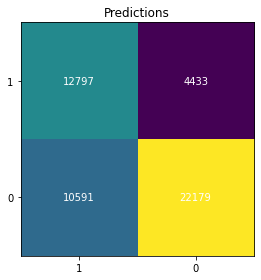

Recall: 0.7427161926871735
Precision: 0.5471609372327689
F_2 score: 0.6931685227715907
Accruacy: 0.69952
----------------------------------------------------------------------------------------------------


In [41]:
degrees, gammas, lambdas_ = [1], [0.001], [0, 0.1, 0.01]
max_iter, val_iter = 1000, 200
method_train, method_loss = reg_logistic_regression, calculate_loss
grid_search(y_val, tX_val, val_iter, method_train, method_loss, y_train, tX_train, max_iter, degrees, gammas, lambdas_)

In: Degree 3, Gamma 0.001, Lambda 0


In step: 100%|███████████████████████████████| 200/200 [00:07<00:00, 25.30it/s]


In run: 0, trained. Train loss: 3204723.7498977706, Val loss: 811581.2510342761.


In step: 100%|███████████████████████████████| 200/200 [00:08<00:00, 24.94it/s]


In run: 1, trained. Train loss: 3207756.0419376977, Val loss: 811169.62947415.


In step: 100%|███████████████████████████████| 200/200 [00:07<00:00, 27.34it/s]


In run: 2, trained. Train loss: 3193538.6556777563, Val loss: 808843.9985345674.


In step: 100%|███████████████████████████████| 200/200 [00:07<00:00, 27.41it/s]


In run: 3, trained. Train loss: 3195563.380784114, Val loss: 807836.4819742902.


In step: 100%|███████████████████████████████| 200/200 [00:07<00:00, 27.26it/s]


In run: 4, trained. Train loss: 3191380.1832593833, Val loss: 806634.9808359193.
Best weights from iteration 1000
TP: 15371, TN: 20672, FP: 12098, FN: 1859


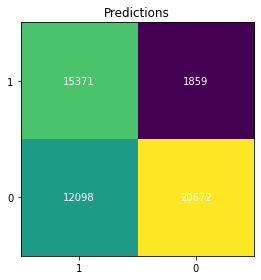

Recall: 0.8921067904817179
Precision: 0.5595762495904474
F_2 score: 0.7973420203550197
Accruacy: 0.72086
----------------------------------------------------------------------------------------------------
In: Degree 3, Gamma 0.001, Lambda 0.5


In step: 100%|███████████████████████████████| 200/200 [00:07<00:00, 26.20it/s]


In run: 0, trained. Train loss: 3519177.602412751, Val loss: 807442.5092789376.


In step: 100%|███████████████████████████████| 200/200 [00:07<00:00, 26.24it/s]


In run: 1, trained. Train loss: 3586622.907050317, Val loss: 810735.5573937518.


In step: 100%|███████████████████████████████| 200/200 [00:07<00:00, 26.16it/s]


In run: 2, trained. Train loss: 3588377.404198135, Val loss: 808096.4988492867.


In step: 100%|███████████████████████████████| 200/200 [00:07<00:00, 27.12it/s]


In run: 3, trained. Train loss: 3574455.6585655925, Val loss: 804430.5627587959.


In step: 100%|███████████████████████████████| 200/200 [00:08<00:00, 24.86it/s]


In run: 4, trained. Train loss: 3565669.086987984, Val loss: 798189.2725758438.
Best weights from iteration 1000
TP: 15470, TN: 20149, FP: 12621, FN: 1760


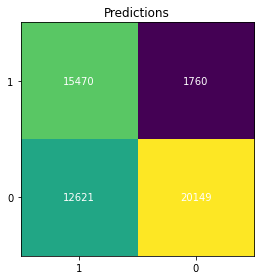

Recall: 0.897852582704585
Precision: 0.5507101918764017
F_2 score: 0.7973322612899568
Accruacy: 0.71238
----------------------------------------------------------------------------------------------------
In: Degree 3, Gamma 0.001, Lambda 0.1


In step: 100%|███████████████████████████████| 200/200 [00:07<00:00, 26.02it/s]


In run: 0, trained. Train loss: 3234865.459136095, Val loss: 808503.9356670037.


In step: 100%|███████████████████████████████| 200/200 [00:07<00:00, 25.21it/s]


In run: 1, trained. Train loss: 3247890.5214420925, Val loss: 808774.1724786739.


In step: 100%|███████████████████████████████| 200/200 [00:07<00:00, 25.91it/s]


In run: 2, trained. Train loss: 3292502.003784805, Val loss: 812756.3350130755.


In step: 100%|███████████████████████████████| 200/200 [00:07<00:00, 25.88it/s]


In run: 3, trained. Train loss: 3288285.6026808685, Val loss: 806533.3242132312.


In step: 100%|███████████████████████████████| 200/200 [00:07<00:00, 25.58it/s]


In run: 4, trained. Train loss: 3288430.1162470104, Val loss: 806456.0142185718.
Best weights from iteration 1000
TP: 15361, TN: 20685, FP: 12085, FN: 1869


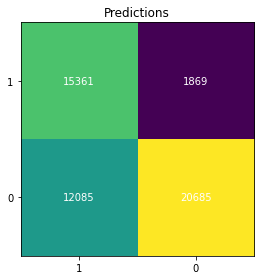

Recall: 0.8915264074289031
Precision: 0.5596808278073307
F_2 score: 0.7970134694809372
Accruacy: 0.72092
----------------------------------------------------------------------------------------------------
In: Degree 3, Gamma 0.001, Lambda 0.01


In step: 100%|███████████████████████████████| 200/200 [00:07<00:00, 25.39it/s]


In run: 0, trained. Train loss: 3211970.3994144225, Val loss: 809958.1204968074.


In step: 100%|███████████████████████████████| 200/200 [00:07<00:00, 25.73it/s]


In run: 1, trained. Train loss: 3199879.4568409235, Val loss: 805979.51023895.


In step: 100%|███████████████████████████████| 200/200 [00:07<00:00, 26.58it/s]


In run: 2, trained. Train loss: 3199980.9611985115, Val loss: 809075.9844977712.


In step: 100%|███████████████████████████████| 200/200 [00:07<00:00, 27.03it/s]


In run: 3, trained. Train loss: 3203228.5895798095, Val loss: 807363.1361298759.


In step: 100%|███████████████████████████████| 200/200 [00:07<00:00, 27.20it/s]


In run: 4, trained. Train loss: 3203035.740008238, Val loss: 807471.6802204044.
Best weights from iteration 400
TP: 15363, TN: 20672, FP: 12098, FN: 1867


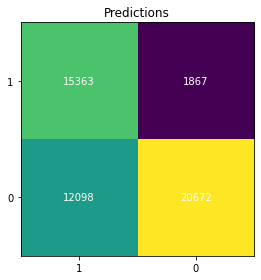

Recall: 0.891642484039466
Precision: 0.5594479443574524
F_2 score: 0.7969931833037631
Accruacy: 0.7207
----------------------------------------------------------------------------------------------------


In [42]:
degrees, gammas, lambdas_ = [3], [0.001], [0, 0.5, 0.1, 0.01]
max_iter, val_iter = 1000, 200
method_train, method_loss = reg_logistic_regression, calculate_loss
grid_search(y_val, tX_val, val_iter, method_train, method_loss, y_train, tX_train, max_iter, degrees, gammas, lambdas_)

In: Degree 5, Gamma 0.001, Lambda 0


In step:   0%|                                         | 0/200 [00:00<?, ?it/s]C:\Users\ojkbe\Desktop\Master\SEMP\Studium\Machine Learning\pyth\ml-project-1-mgo\project1\scripts\implementations.py:169: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-t))
In step: 100%|███████████████████████████████| 200/200 [00:12<00:00, 15.73it/s]


In run: 0, trained. Train loss: 3207457.1585557833, Val loss: 807554.3472482782.


In step: 100%|███████████████████████████████| 200/200 [00:12<00:00, 15.69it/s]


In run: 1, trained. Train loss: 3233243.6914302385, Val loss: 812634.5941566438.


In step: 100%|███████████████████████████████| 200/200 [00:12<00:00, 15.69it/s]


In run: 2, trained. Train loss: 2802090.8406955176, Val loss: 707775.1999538562.


In step: 100%|███████████████████████████████| 200/200 [00:12<00:00, 15.40it/s]


In run: 3, trained. Train loss: 2687260.8226954713, Val loss: 668783.0355269411.


In step: 100%|███████████████████████████████| 200/200 [00:13<00:00, 15.21it/s]


In run: 4, trained. Train loss: 3528330.963926039, Val loss: 916829.7034785614.
Best weights from iteration 800
TP: 10574, TN: 23462, FP: 9308, FN: 6656


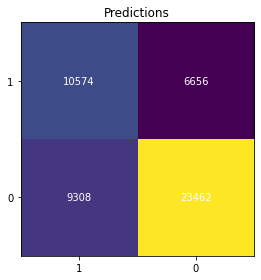

Recall: 0.6136970400464307
Precision: 0.5318378432753245
F_2 score: 0.5953694736605031
Accruacy: 0.68072
----------------------------------------------------------------------------------------------------
In: Degree 5, Gamma 0.001, Lambda 0.5


In step: 100%|███████████████████████████████| 200/200 [00:13<00:00, 15.32it/s]


In run: 0, trained. Train loss: 10553002.683578182, Val loss: 780122.7537815126.


In step: 100%|███████████████████████████████| 200/200 [00:14<00:00, 13.44it/s]


In run: 1, trained. Train loss: 13534264.711127594, Val loss: 800970.5235962337.


In step: 100%|███████████████████████████████| 200/200 [00:17<00:00, 11.55it/s]


In run: 2, trained. Train loss: 15467610.839865288, Val loss: 659467.5366832477.


In step: 100%|███████████████████████████████| 200/200 [00:14<00:00, 13.74it/s]


In run: 3, trained. Train loss: 16378117.118387919, Val loss: 714233.1973070038.


In step: 100%|███████████████████████████████| 200/200 [00:14<00:00, 14.17it/s]


In run: 4, trained. Train loss: 18444814.141762502, Val loss: 821539.5208943734.
Best weights from iteration 600
TP: 6404, TN: 29260, FP: 3510, FN: 10826


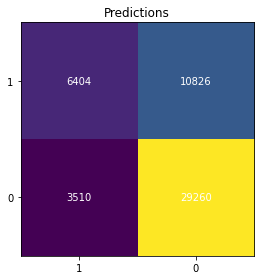

Recall: 0.37167730702263496
Precision: 0.6459552148476901
F_2 score: 0.40616992668138113
Accruacy: 0.71328
----------------------------------------------------------------------------------------------------
In: Degree 5, Gamma 0.001, Lambda 0.1


In step: 100%|███████████████████████████████| 200/200 [00:14<00:00, 14.27it/s]


In run: 0, trained. Train loss: 4399731.224757386, Val loss: 745015.9859210539.


In step: 100%|███████████████████████████████| 200/200 [00:15<00:00, 13.18it/s]


In run: 1, trained. Train loss: 5021693.782930977, Val loss: 662406.7976793803.


In step: 100%|███████████████████████████████| 200/200 [00:15<00:00, 13.30it/s]


In run: 2, trained. Train loss: 6325319.4495779, Val loss: 806936.3130032416.


In step: 100%|███████████████████████████████| 200/200 [00:15<00:00, 13.04it/s]


In run: 3, trained. Train loss: 6771760.817434102, Val loss: 732161.458226763.


In step: 100%|███████████████████████████████| 200/200 [00:16<00:00, 12.06it/s]


In run: 4, trained. Train loss: 7028910.601220133, Val loss: 640023.4498028285.
Best weights from iteration 1000
TP: 13881, TN: 22197, FP: 10573, FN: 3349


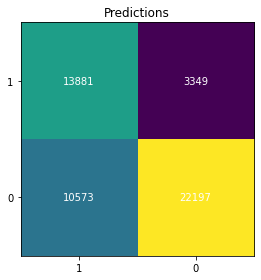

Recall: 0.8056297156123041
Precision: 0.5676371963686923
F_2 score: 0.7433011330777304
Accruacy: 0.72156
----------------------------------------------------------------------------------------------------
In: Degree 5, Gamma 0.001, Lambda 0.01


In step: 100%|███████████████████████████████| 200/200 [00:15<00:00, 12.84it/s]


In run: 0, trained. Train loss: 3008887.2901367825, Val loss: 712789.1483784831.


In step: 100%|███████████████████████████████| 200/200 [00:14<00:00, 13.38it/s]


In run: 1, trained. Train loss: 2910207.6306511983, Val loss: 666818.8683899528.


In step: 100%|███████████████████████████████| 200/200 [00:14<00:00, 13.93it/s]


In run: 2, trained. Train loss: 2812539.485249587, Val loss: 614545.5855203475.


In step: 100%|███████████████████████████████| 200/200 [00:14<00:00, 13.88it/s]


In run: 3, trained. Train loss: 3159092.562377647, Val loss: 677982.6094745288.


In step: 100%|███████████████████████████████| 200/200 [00:14<00:00, 14.00it/s]


In run: 4, trained. Train loss: 3194694.284789984, Val loss: 675444.836891108.
Best weights from iteration 600
TP: 10671, TN: 25987, FP: 6783, FN: 6559


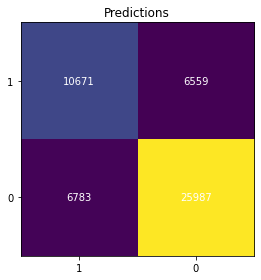

Recall: 0.6193267556587347
Precision: 0.6113784805775181
F_2 score: 0.617720610368861
Accruacy: 0.73316
----------------------------------------------------------------------------------------------------


In [16]:
degrees, gammas, lambdas_ = [5], [0.001], [0, 0.5, 0.1, 0.01]
max_iter, val_iter = 1000, 200
method_train, method_loss = reg_logistic_regression, calculate_loss
grid_search(y_val, tX_val, val_iter, method_train, method_loss, y_train, tX_train, max_iter, degrees, gammas, lambdas_)

## learning_by_newton_method and log loss

In: Degree 1, Gamma 0.001, Lambda None


100%|████████████████████████████████████████| 200/200 [00:16<00:00, 11.94it/s]


In run: 0, trained. Train loss: 131208.12504006724, Val loss: 32806.88910189261.


100%|████████████████████████████████████████| 200/200 [00:16<00:00, 12.08it/s]


In run: 1, trained. Train loss: 126063.5676384035, Val loss: 31523.011845114994.


100%|████████████████████████████████████████| 200/200 [00:18<00:00, 11.01it/s]


In run: 2, trained. Train loss: 122426.58384378078, Val loss: 30614.483349520564.


100%|████████████████████████████████████████| 200/200 [00:17<00:00, 11.67it/s]


In run: 3, trained. Train loss: 119833.01631337975, Val loss: 29965.950727407486.


100%|████████████████████████████████████████| 200/200 [00:15<00:00, 12.58it/s]


In run: 4, trained. Train loss: 117979.71815623445, Val loss: 29502.06299613028.
Best weights from iteration 1000
TP: 7844, TN: 29193, FP: 3577, FN: 9386


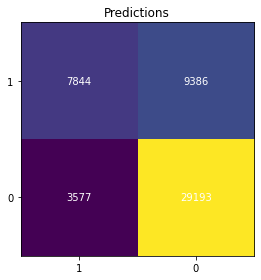

Recall: 0.4552524666279745
Precision: 0.6868050083180107
F_2 score: 0.4881691788750451
Accruacy: 0.74074
----------------------------------------------------------------------------------------------------
In: Degree 3, Gamma 0.001, Lambda None


100%|████████████████████████████████████████| 200/200 [00:48<00:00,  4.12it/s]


In run: 0, trained. Train loss: 125290.4103089651, Val loss: 31337.973413651154.


100%|████████████████████████████████████████| 200/200 [00:52<00:00,  3.83it/s]


In run: 1, trained. Train loss: 115743.45680571237, Val loss: 28963.464528961507.


100%|████████████████████████████████████████| 200/200 [00:48<00:00,  4.14it/s]


In run: 2, trained. Train loss: 108610.57553280366, Val loss: 27190.41275269894.


100%|████████████████████████████████████████| 200/200 [00:52<00:00,  3.79it/s]


In run: 3, trained. Train loss: 103134.97694973355, Val loss: 25830.21811550058.


100%|████████████████████████████████████████| 200/200 [00:49<00:00,  4.03it/s]


In run: 4, trained. Train loss: 98856.9323463346, Val loss: 24768.3345048503.
Best weights from iteration 1000
TP: 5524, TN: 32022, FP: 748, FN: 11706


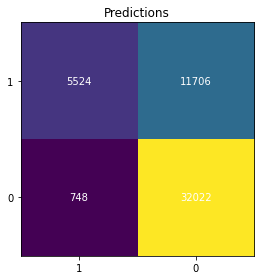

Recall: 0.32060359837492747
Precision: 0.8807397959183674
F_2 score: 0.3673263113097138
Accruacy: 0.75092
----------------------------------------------------------------------------------------------------
In: Degree 5, Gamma 0.001, Lambda None


100%|████████████████████████████████████████| 200/200 [01:26<00:00,  2.32it/s]


In run: 0, trained. Train loss: 124359.84436283386, Val loss: 31102.241487599873.


100%|████████████████████████████████████████| 200/200 [01:31<00:00,  2.20it/s]


In run: 1, trained. Train loss: 114170.66397869377, Val loss: 28563.988132429447.


100%|████████████████████████████████████████| 200/200 [01:30<00:00,  2.21it/s]


In run: 2, trained. Train loss: 106595.19000480589, Val loss: 26677.374986401985.


100%|████████████████████████████████████████| 200/200 [01:32<00:00,  2.16it/s]


In run: 3, trained. Train loss: 100825.09007085129, Val loss: 25241.000471061907.


100%|████████████████████████████████████████| 200/200 [01:33<00:00,  2.14it/s]


In run: 4, trained. Train loss: 96364.77304894684, Val loss: 24131.293943257333.
Best weights from iteration 1000
TP: 6331, TN: 31996, FP: 774, FN: 10899


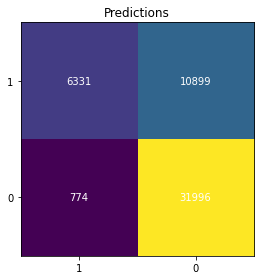

Recall: 0.3674405107370865
Precision: 0.8910626319493314
F_2 score: 0.4163761920420914
Accruacy: 0.76654
----------------------------------------------------------------------------------------------------
In: Degree 7, Gamma 0.001, Lambda None


100%|████████████████████████████████████████| 200/200 [02:11<00:00,  1.52it/s]


In run: 0, trained. Train loss: 123740.25768170069, Val loss: 30958.900419731603.


100%|████████████████████████████████████████| 200/200 [02:18<00:00,  1.44it/s]


In run: 1, trained. Train loss: 113087.36115284928, Val loss: 28313.520498162234.


100%|████████████████████████████████████████| 200/200 [02:21<00:00,  1.41it/s]


In run: 2, trained. Train loss: 105159.30248593897, Val loss: 26346.00378515978.


100%|████████████████████████████████████████| 200/200 [02:15<00:00,  1.47it/s]


In run: 3, trained. Train loss: 99123.86149886381, Val loss: 24850.216491670075.


100%|████████████████████████████████████████| 200/200 [02:07<00:00,  1.56it/s]


In run: 4, trained. Train loss: 94475.27485798646, Val loss: 23700.603656926647.
Best weights from iteration 1000
TP: 6957, TN: 31920, FP: 850, FN: 10273


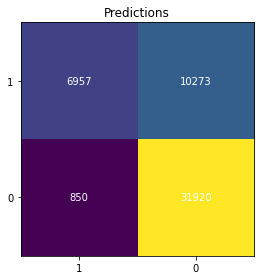

Recall: 0.40377248984329656
Precision: 0.8911233508389906
F_2 score: 0.4533606162107211
Accruacy: 0.77754
----------------------------------------------------------------------------------------------------


In [18]:
degrees, gammas, lambdas_ = [1, 3, 5, 7], [0.001], [None]
max_iter, val_iter = 1000, 200
method_train, method_loss = learning_by_newton_method, calculate_loss
grid_search(y_val, tX_val, val_iter, method_train, method_loss, y_train, tX_train, max_iter, degrees, gammas, lambdas_)

## Second Training: PCA

In [19]:
# Save standardized dataset
import copy
tX_c = copy.deepcopy(tX)
y_c = copy.deepcopy(y)

In [25]:
# Calculating the covariance matrix
covariance_matrix = np.cov(tX.T)
eigen_values, eigen_vectors = np.linalg.eig(covariance_matrix)
#print("Eigenvector: \n", eigen_vectors,"\n")
#print("Eigenvalues: \n", eigen_values, "\n")
# Calculating the explained variance on each of components
variance_explained = []
for i in eigen_values:
    variance_explained.append((i / sum(eigen_values)) * 100)

print("Explained Variance", variance_explained)

# Identifying components that explain at least 95%
cumulative_variance_explained = np.cumsum(variance_explained)
print("Cumlative Explained Vairiance", cumulative_variance_explained)

Explained Variance [23.377100550544966, 10.251418313091854, 8.847521803006995, 6.737975076344272, 5.723443894687943, 5.114774523007796, 4.686539240476555, 4.451879374604431, 3.63122369376223, 3.5462832718696213, 3.356690214821012, 2.9109500027544573, 2.4708022851760303, 2.1181967992150628, 1.919612617644611, 1.868739070454677, 1.5986812799268133, 0.04077743534279372, 0.05985095280576075, 0.0831325320631536, 0.23941969520528084, 0.2701951387528673, 0.3137604840383286, 0.5903578713007152, 0.7207040106393094, 0.8286426595396728, 1.0217958067252755, 0.9256400159824689, 1.1595188658048068, 1.134372520410223]
Cumlative Explained Vairiance [ 23.37710055  33.62851886  42.47604067  49.21401574  54.93745964
  60.05223416  64.7387734   69.19065278  72.82187647  76.36815974
  79.72484996  82.63579996  85.10660224  87.22479904  89.14441166
  91.01315073  92.61183201  92.65260945  92.7124604   92.79559293
  93.03501263  93.30520777  93.61896825  94.20932612  94.93003013
  95.75867279  96.7804686   9

In [32]:
# get the features with the highest explained variance
low_to_high = np.argsort(variance_explained)
high_to_low = np.flip(low_to_high)
high_to_low

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       28, 29, 26, 27, 25, 24, 23, 22, 21, 20, 19, 18, 17], dtype=int64)

In [37]:
expl = 0
features_to_95 = []
for f in high_to_low:
    if expl <= 95:
        features_to_95.append(f)
    expl += variance_explained[f]
    print("Features: {} explain {} %".format(f, expl))

Features: 0 explain 23.377100550544966 %
Features: 1 explain 33.62851886363682 %
Features: 2 explain 42.47604066664381 %
Features: 3 explain 49.21401574298808 %
Features: 4 explain 54.93745963767603 %
Features: 5 explain 60.052234160683824 %
Features: 6 explain 64.73877340116037 %
Features: 7 explain 69.1906527757648 %
Features: 8 explain 72.82187646952704 %
Features: 9 explain 76.36815974139667 %
Features: 10 explain 79.72484995621768 %
Features: 11 explain 82.63579995897214 %
Features: 12 explain 85.10660224414818 %
Features: 13 explain 87.22479904336323 %
Features: 14 explain 89.14441166100785 %
Features: 15 explain 91.01315073146253 %
Features: 16 explain 92.61183201138934 %
Features: 28 explain 93.77135087719415 %
Features: 29 explain 94.90572339760438 %
Features: 26 explain 95.92751920432966 %
Features: 27 explain 96.85315922031212 %
Features: 25 explain 97.68180187985179 %
Features: 24 explain 98.4025058904911 %
Features: 23 explain 98.99286376179181 %
Features: 22 explain 99.30

Reached 95% with feature 26

In [38]:
features_to_95

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 28, 29, 26]

In [40]:
# Using  components (because those explain more than 95%)
projection_matrix = (eigen_vectors.T[:][features_to_95]).T

In [42]:
# Project tX onto PC space
tX_pca = tX.dot(projection_matrix)

Try PCA on one of the best prediction methods

In [44]:
# from train take 20% as a validation set and 20% as a test set
tX_pca_train, tX_pca_val, y_train, y_val = split_data(tX_pca, y, ratio=0.8, seed=1)
print("Size of the train set: {}. Size of the validation set: {}.".format(tX_train.shape[0], tX_val.shape[0]))

Size of the train set: 200000. Size of the validation set: 50000.


In: Degree 1, Gamma None, Lambda 0
In run: 0, trained. Train loss: 0.14646807986696844, Val loss: 0.14767330973552134.
Best weights from iteration 1
TP: 811, TN: 32611, FP: 159, FN: 16419


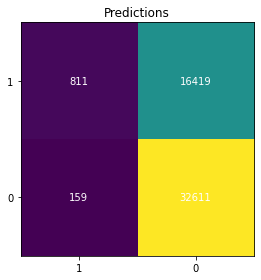

Recall: 0.04706906558328497
Precision: 0.8360824742268042
F_2 score: 0.058019745314064966
Accruacy: 0.66844
----------------------------------------------------------------------------------------------------
In: Degree 1, Gamma None, Lambda 0.5
In run: 0, trained. Train loss: 0.14954347569072923, Val loss: 0.15078350211010202.
Best weights from iteration 1
TP: 30, TN: 32765, FP: 5, FN: 17200


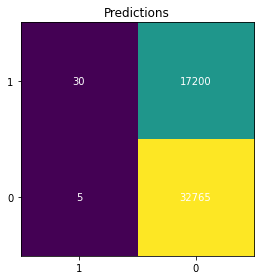

Recall: 0.0017411491584445734
Precision: 0.8571428571428571
F_2 score: 0.0021753317380900587
Accruacy: 0.6559
----------------------------------------------------------------------------------------------------
In: Degree 1, Gamma None, Lambda 0.1
In run: 0, trained. Train loss: 0.1467596212570779, Val loss: 0.14799163409042315.
Best weights from iteration 1
TP: 457, TN: 32688, FP: 82, FN: 16773


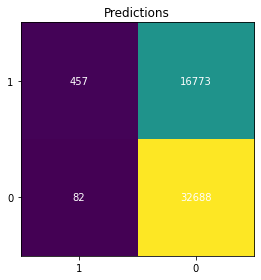

Recall: 0.026523505513639002
Precision: 0.8478664192949907
F_2 score: 0.03289710476684087
Accruacy: 0.6629
----------------------------------------------------------------------------------------------------
In: Degree 1, Gamma None, Lambda 0.01
In run: 0, trained. Train loss: 0.14647204162338637, Val loss: 0.14768167831994963.
Best weights from iteration 1
TP: 769, TN: 32619, FP: 151, FN: 16461


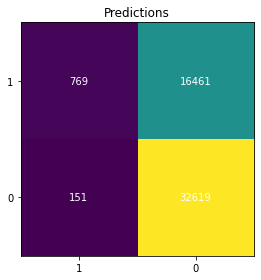

Recall: 0.044631456761462567
Precision: 0.8358695652173913
F_2 score: 0.055054410080183275
Accruacy: 0.66776
----------------------------------------------------------------------------------------------------
In: Degree 1, Gamma None, Lambda 0.001
In run: 0, trained. Train loss: 0.14646812094525052, Val loss: 0.14767381845366595.
Best weights from iteration 1
TP: 808, TN: 32611, FP: 159, FN: 16422


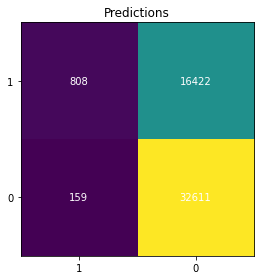

Recall: 0.04689495066744051
Precision: 0.8355739400206825
F_2 score: 0.057807603703120755
Accruacy: 0.66838
----------------------------------------------------------------------------------------------------
In: Degree 3, Gamma None, Lambda 0
In run: 0, trained. Train loss: 0.07833346265840392, Val loss: 0.0786926899828039.
Best weights from iteration 1
TP: 9608, TN: 29059, FP: 3711, FN: 7622


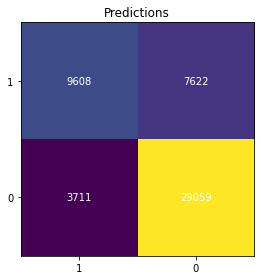

Recall: 0.5576320371445154
Precision: 0.7213754786395375
F_2 score: 0.584151071875874
Accruacy: 0.77334
----------------------------------------------------------------------------------------------------
In: Degree 3, Gamma None, Lambda 0.5
In run: 0, trained. Train loss: 0.08686538480736916, Val loss: 0.08743335455608905.
Best weights from iteration 1
TP: 5732, TN: 30841, FP: 1929, FN: 11498


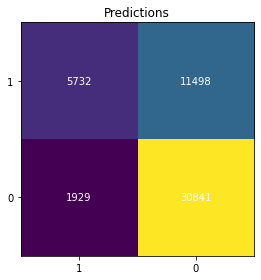

Recall: 0.3326755658734765
Precision: 0.748205195144237
F_2 score: 0.37424426424308904
Accruacy: 0.73146
----------------------------------------------------------------------------------------------------
In: Degree 3, Gamma None, Lambda 0.1
In run: 0, trained. Train loss: 0.08156841233560769, Val loss: 0.08198797928463175.
Best weights from iteration 1
TP: 7743, TN: 30010, FP: 2760, FN: 9487


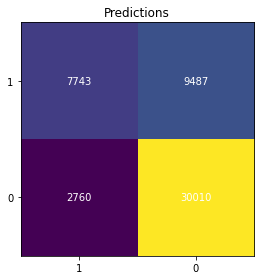

Recall: 0.4493905977945444
Precision: 0.7372179377320766
F_2 score: 0.4874532566133236
Accruacy: 0.75506
----------------------------------------------------------------------------------------------------
In: Degree 3, Gamma None, Lambda 0.01
In run: 0, trained. Train loss: 0.07868856727886919, Val loss: 0.07905750851932872.
Best weights from iteration 1
TP: 9193, TN: 29308, FP: 3462, FN: 8037


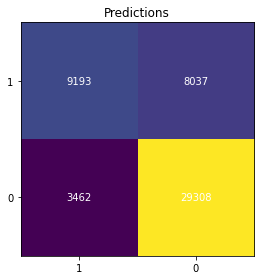

Recall: 0.5335461404526988
Precision: 0.7264322402212564
F_2 score: 0.5634692001225866
Accruacy: 0.77002
----------------------------------------------------------------------------------------------------
In: Degree 3, Gamma None, Lambda 0.001
In run: 0, trained. Train loss: 0.07834050659238138, Val loss: 0.07870093095791482.
Best weights from iteration 1
TP: 9556, TN: 29096, FP: 3674, FN: 7674


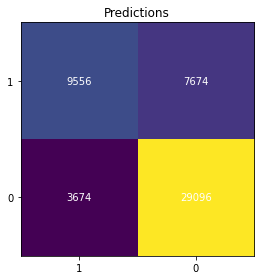

Recall: 0.5546140452698781
Precision: 0.7222978080120938
F_2 score: 0.5816189896530737
Accruacy: 0.77304
----------------------------------------------------------------------------------------------------
In: Degree 5, Gamma None, Lambda 0
In run: 0, trained. Train loss: 0.07524908681594299, Val loss: 0.07557726592393282.
Best weights from iteration 1
TP: 10260, TN: 29021, FP: 3749, FN: 6970


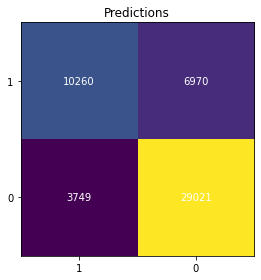

Recall: 0.5954730121880442
Precision: 0.7323863230780213
F_2 score: 0.6186014542560504
Accruacy: 0.78562
----------------------------------------------------------------------------------------------------
In: Degree 5, Gamma None, Lambda 0.5
In run: 0, trained. Train loss: 0.08396418250165194, Val loss: 0.08468377266394828.
Best weights from iteration 1
TP: 6727, TN: 30511, FP: 2259, FN: 10503


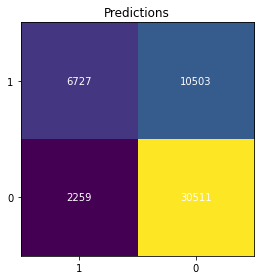

Recall: 0.39042367962855484
Precision: 0.7486089472512798
F_2 score: 0.4317382486586399
Accruacy: 0.74476
----------------------------------------------------------------------------------------------------
In: Degree 5, Gamma None, Lambda 0.1
In run: 0, trained. Train loss: 0.07843015859947525, Val loss: 0.07875149438921192.
Best weights from iteration 1
TP: 8649, TN: 29814, FP: 2956, FN: 8581


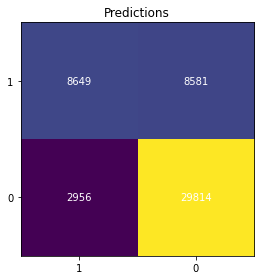

Recall: 0.5019733023795705
Precision: 0.745282205945713
F_2 score: 0.5370381868984788
Accruacy: 0.76926
----------------------------------------------------------------------------------------------------
In: Degree 5, Gamma None, Lambda 0.01
In run: 0, trained. Train loss: 0.07575767365660435, Val loss: 0.0760483288927314.
Best weights from iteration 1
TP: 9909, TN: 29232, FP: 3538, FN: 7321


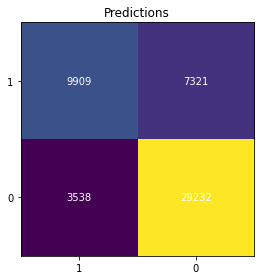

Recall: 0.5751015670342426
Precision: 0.7368929872834089
F_2 score: 0.6015151699102796
Accruacy: 0.78282
----------------------------------------------------------------------------------------------------
In: Degree 5, Gamma None, Lambda 0.001
In run: 0, trained. Train loss: 0.07526804839747639, Val loss: 0.07558975731721686.
Best weights from iteration 1
TP: 10220, TN: 29063, FP: 3707, FN: 7010


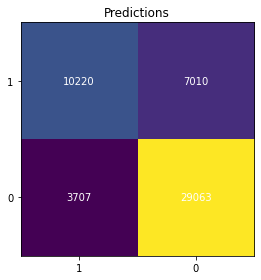

Recall: 0.5931514799767846
Precision: 0.7338263804121491
F_2 score: 0.6167996427148841
Accruacy: 0.78566
----------------------------------------------------------------------------------------------------
In: Degree 7, Gamma None, Lambda 0
In run: 0, trained. Train loss: 0.07413595329724013, Val loss: 0.07448130822256151.
Best weights from iteration 1
TP: 10518, TN: 29038, FP: 3732, FN: 6712


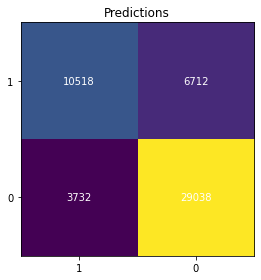

Recall: 0.6104468949506674
Precision: 0.7381052631578947
F_2 score: 0.6323193459179993
Accruacy: 0.79112
----------------------------------------------------------------------------------------------------
In: Degree 7, Gamma None, Lambda 0.5
In run: 0, trained. Train loss: 0.08220680712787251, Val loss: 0.08273168595577124.
Best weights from iteration 1
TP: 7135, TN: 30398, FP: 2372, FN: 10095


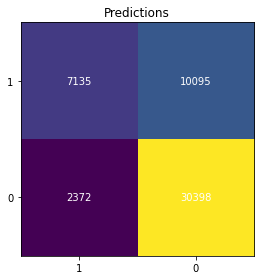

Recall: 0.414103308183401
Precision: 0.7504996318502156
F_2 score: 0.45488160964973795
Accruacy: 0.75066
----------------------------------------------------------------------------------------------------
In: Degree 7, Gamma None, Lambda 0.1
In run: 0, trained. Train loss: 0.07729609825062701, Val loss: 0.07785549751988836.
Best weights from iteration 1
TP: 8978, TN: 29782, FP: 2988, FN: 8252


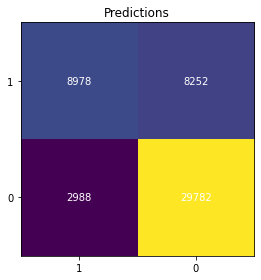

Recall: 0.5210679048171794
Precision: 0.7502924954036436
F_2 score: 0.554978611873501
Accruacy: 0.7752
----------------------------------------------------------------------------------------------------
In: Degree 7, Gamma None, Lambda 0.01
In run: 0, trained. Train loss: 0.07469731127423247, Val loss: 0.075053867032455.
Best weights from iteration 1
TP: 10137, TN: 29239, FP: 3531, FN: 7093


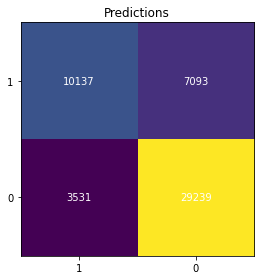

Recall: 0.5883343006384214
Precision: 0.7416593503072871
F_2 score: 0.6137090134159927
Accruacy: 0.78752
----------------------------------------------------------------------------------------------------
In: Degree 7, Gamma None, Lambda 0.001
In run: 0, trained. Train loss: 0.07416798548269606, Val loss: 0.0745114119061572.
Best weights from iteration 1
TP: 10458, TN: 29067, FP: 3703, FN: 6772


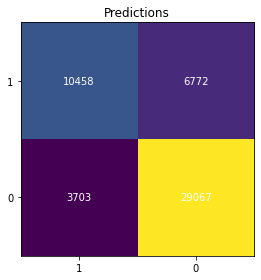

Recall: 0.6069645966337783
Precision: 0.7385071675729116
F_2 score: 0.6293857801422709
Accruacy: 0.7905
----------------------------------------------------------------------------------------------------


In [45]:
# no gamma
degrees, gammas, lambdas_ = [1, 3, 5, 7], [None], [0, 0.5, 0.1, 0.01, 0.001]
# only 1 iterations as there are no steps
max_iter, val_iter = 1, 1
method_train, method_loss = ridge_regression, compute_loss_mse
grid_search(y_val, tX_pca_val, val_iter, method_train, method_loss, y_train, tX_pca_train, max_iter, degrees, gammas, lambdas_)

## Third Training: Splitting up by Feature 22

Features:

0 DER_mass_MMC
1 DER_mass_transverse_met_lep
2 DER_mass_vis
3 DER_pt_h
4 DER_deltaeta_jet_jet
5 DER_mass_jet_jet
6 DER_prodeta_jet_jet
7 DER_deltar_tau_lep
8 DER_pt_tot
9 DER_sum_pt
10 DER_pt_ratio_lep_tau
11 DER_met_phi_centrality
12 DER_lep_eta_centrality
13 PRI_tau_pt
14 PRI_tau_eta
15 PRI_tau_phi
16 PRI_lep_pt
17 PRI_lep_eta
18 PRI_lep_phi
19 PRI_met
20 PRI_met_phi
21 PRI_met_sumet
22 PRI_jet_num
23 PRI_jet_leading_pt
24 PRI_jet_leading_eta
25 PRI_jet_leading_phi
26 PRI_jet_subleading_pt
27 PRI_jet_subleading_eta
28 PRI_jet_subleading_phi
29 PRI_jet_all_pt


From the documentary: PRI jet num The number of jets (integer with value of 0, 1, 2 or 3; possible larger values have
been capped at 3).

4 DER_deltaeta_jet_jet	undefined if PRI jet num ≤ 1 <br />
5 DER_mass_jet_jet	undefined if PRI jet num ≤ 1 <br />
6 DER_prodeta_jet_jet	undefined if PRI jet num ≤ 1 <br />
8 DER_pt_tot		undefined if PRI jet num = 0 <br />
9 DER_sum_pt		undefined if PRI jet num = 0 <br />
23 PRI_jet_leading_pt		undefined if PRI jet num = 0 <br />
24 PRI_jet_leading_eta		undefined if PRI jet num = 0 <br />
25 PRI_jet_leading_phi		undefined if PRI jet num = 0 <br />
26 PRI_jet_subleading_pt	undefined if PRI jet num ≤ 1 <br />
27 PRI_jet_subleading_eta	undefined if PRI jet num ≤ 1 <br />
28 PRI_jet_subleading_phi	undefined if PRI jet num ≤ 1

In [49]:
# load original data again, only for the feature 22
# Train set
DATA_TRAIN_PATH = '../data/train.csv' # TODO: download train data and supply path here 
with ZipFile('../data/train.csv.zip', 'r') as zip:
    zip.extractall('../data')
_, tX_org, _ = load_csv_data(DATA_TRAIN_PATH)

In [54]:
# Split up the dataset by feature 22 by 0, 1 and >1
feature22 = tX_org[:, 22]
tX_0 = tX[feature22 == 0]
y_0 = y[feature22 == 0]
tX_1 = tX[feature22 == 1]
y_1 = y[feature22 == 1]
tX_2 = tX[feature22 > 1]
y_2 = y[feature22 > 1]

print("Train - Shape 0: {}, Shape 1: {}, Shape 2: {}".format(tX_0.shape, tX_1.shape, tX_2.shape))
print("Label - Shape 0: {}, Shape 1: {}, Shape 2: {}".format(y_0.shape, y_1.shape, y_2.shape))

Train - Shape 0: (99913, 30), Shape 1: (77544, 30), Shape 2: (72543, 30)
Label - Shape 0: (99913,), Shape 1: (77544,), Shape 2: (72543,)


In [56]:
# from train take 20% as a validation set and 20% as a test set
tX_0_train, tX_0_val, y_0_train, y_0_val = split_data(tX_0, y_0, ratio=0.8, seed=1)
print("Size of the train set 0: {}. Size of the validation set: {}.".format(tX_0_train.shape[0], tX_0_val.shape[0]))
tX_1_train, tX_1_val, y_1_train, y_1_val = split_data(tX_1, y_1, ratio=0.8, seed=1)
print("Size of the train set 0: {}. Size of the validation set: {}.".format(tX_1_train.shape[0], tX_1_val.shape[0]))
tX_2_train, tX_2_val, y_2_train, y_2_val = split_data(tX_2, y_2, ratio=0.8, seed=1)
print("Size of the train set 0: {}. Size of the validation set: {}.".format(tX_2_train.shape[0], tX_2_val.shape[0]))

Size of the train set 0: 79930. Size of the validation set: 19983.
Size of the train set 0: 62035. Size of the validation set: 15509.
Size of the train set 0: 58034. Size of the validation set: 14509.


Train three different models on each dataset and calculate the accuracy by weighing the numbers of datapoints

Ridge Regression on all three sets

Training and testing data set 0
In: Degree 7, Gamma None, Lambda 0.001
In run: 0, trained. Train loss: 0.058525303988258, Val loss: 0.13344821432411896.
Best weights from iteration 1
TP: 3003, TN: 13890, FP: 1004, FN: 2086


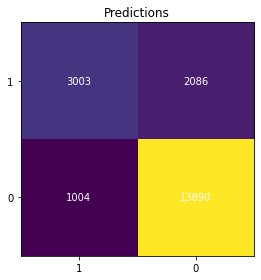

Recall: 0.5900962861072903
Precision: 0.7494384826553532
F_2 score: 0.6163034109099864
Accruacy: 0.845368563278787
----------------------------------------------------------------------------------------------------
In: Degree 7, Gamma None, Lambda 0.0001
In run: 0, trained. Train loss: 0.05847300186407424, Val loss: 0.31517817423598526.
Best weights from iteration 1
TP: 3020, TN: 13881, FP: 1013, FN: 2069


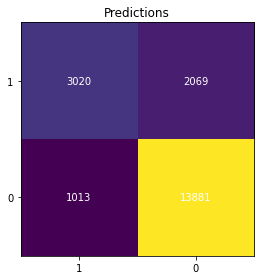

Recall: 0.593436824523482
Precision: 0.748822216712125
F_2 score: 0.6191315757103613
Accruacy: 0.8457689035680328
----------------------------------------------------------------------------------------------------
In: Degree 9, Gamma None, Lambda 0.001
In run: 0, trained. Train loss: 0.057902247565113536, Val loss: 102.57239853888271.
Best weights from iteration 1
TP: 3030, TN: 13909, FP: 985, FN: 2059


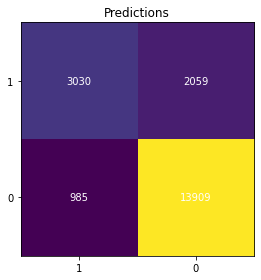

Recall: 0.5954018471212419
Precision: 0.7546699875466999
F_2 score: 0.6216404743342497
Accruacy: 0.8476705199419506
----------------------------------------------------------------------------------------------------
In: Degree 9, Gamma None, Lambda 0.0001
In run: 0, trained. Train loss: 0.05782972664878206, Val loss: 646.6773302135286.
Best weights from iteration 1
TP: 3056, TN: 13906, FP: 988, FN: 2033


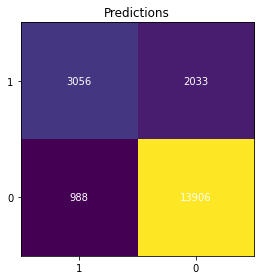

Recall: 0.6005109058754176
Precision: 0.7556874381800198
F_2 score: 0.6262295081967213
Accruacy: 0.8488214982735325
----------------------------------------------------------------------------------------------------
////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
Training and testing data set 1
In: Degree 7, Gamma None, Lambda 0.001
In run: 0, trained. Train loss: 0.07438992667573625, Val loss: 0.07499173854542675.
Best weights from iteration 1
TP: 3792, TN: 8590, FP: 1324, FN: 1803


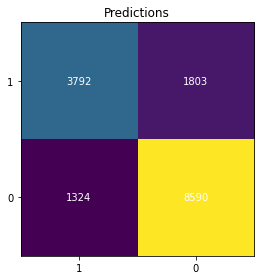

Recall: 0.6777479892761394
Precision: 0.7412040656763096
F_2 score: 0.689554844340995
Accruacy: 0.7983751370172159
----------------------------------------------------------------------------------------------------
In: Degree 7, Gamma None, Lambda 0.0001
In run: 0, trained. Train loss: 0.07433220588134451, Val loss: 0.07503011036173024.
Best weights from iteration 1
TP: 3816, TN: 8560, FP: 1354, FN: 1779


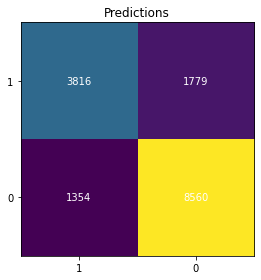

Recall: 0.6820375335120643
Precision: 0.7381044487427466
F_2 score: 0.6925589836660618
Accruacy: 0.7979882648784576
----------------------------------------------------------------------------------------------------
In: Degree 9, Gamma None, Lambda 0.001
In run: 0, trained. Train loss: 0.07253317669993552, Val loss: 0.07363252294235552.
Best weights from iteration 1
TP: 3874, TN: 8600, FP: 1314, FN: 1721


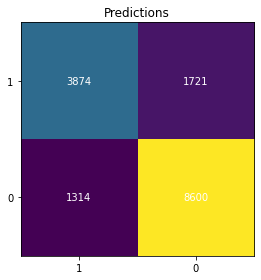

Recall: 0.6924039320822163
Precision: 0.7467232074016962
F_2 score: 0.7026262333139872
Accruacy: 0.804307176478174
----------------------------------------------------------------------------------------------------
In: Degree 9, Gamma None, Lambda 0.0001
In run: 0, trained. Train loss: 0.07245774977141704, Val loss: 0.07365692566719993.
Best weights from iteration 1
TP: 3897, TN: 8577, FP: 1337, FN: 1698


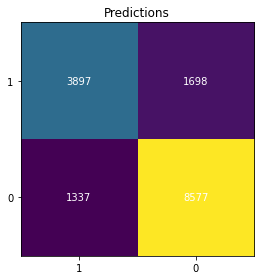

Recall: 0.696514745308311
Precision: 0.7445548337791364
F_2 score: 0.7056203375099588
Accruacy: 0.804307176478174
----------------------------------------------------------------------------------------------------
////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
Training and testing data set 2
In: Degree 7, Gamma None, Lambda 0.001
In run: 0, trained. Train loss: 0.06772503116412117, Val loss: 0.06645393995122907.
Best weights from iteration 1
TP: 5190, TN: 6803, FP: 1245, FN: 1271


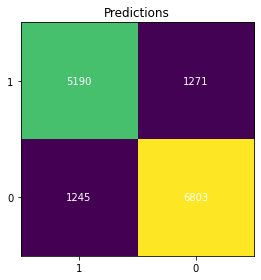

Recall: 0.8032812258164371
Precision: 0.8065268065268065
F_2 score: 0.8039282505653832
Accruacy: 0.826590392170377
----------------------------------------------------------------------------------------------------
In: Degree 7, Gamma None, Lambda 0.0001
In run: 0, trained. Train loss: 0.067685270945737, Val loss: 0.06639593568700247.
Best weights from iteration 1
TP: 5201, TN: 6792, FP: 1256, FN: 1260


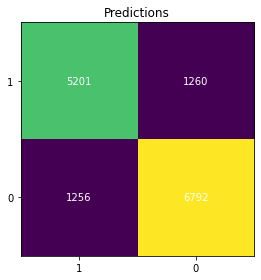

Recall: 0.8049837486457205
Precision: 0.8054824221774818
F_2 score: 0.8050834339494134
Accruacy: 0.826590392170377
----------------------------------------------------------------------------------------------------
In: Degree 9, Gamma None, Lambda 0.001
In run: 0, trained. Train loss: 0.0653614488729765, Val loss: 0.0657261092479916.
Best weights from iteration 1
TP: 5249, TN: 6829, FP: 1219, FN: 1212


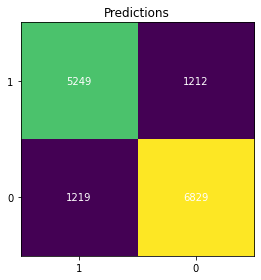

Recall: 0.8124129391735025
Precision: 0.8115337043908473
F_2 score: 0.8122369398365932
Accruacy: 0.8324488248673237
----------------------------------------------------------------------------------------------------
In: Degree 9, Gamma None, Lambda 0.0001
In run: 0, trained. Train loss: 0.06529550837505858, Val loss: 0.06547190877396361.
Best weights from iteration 1
TP: 5253, TN: 6819, FP: 1229, FN: 1208


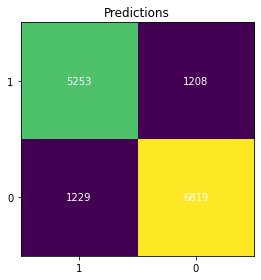

Recall: 0.8130320383841511
Precision: 0.810398025300833
F_2 score: 0.8125038668564004
Accruacy: 0.8320352884416569
----------------------------------------------------------------------------------------------------
////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////


In [61]:
# no gamma
degrees, gammas, lambdas_ = [7, 9], [None], [0.001, 0.0001]
# only 1 iterations as there are no steps
max_iter, val_iter = 1, 1

for i, tr_set in enumerate([[tX_0_train, tX_0_val, y_0_train, y_0_val], [tX_1_train, tX_1_val, y_1_train, y_1_val], [tX_2_train, tX_2_val, y_2_train, y_2_val]]):
    print("Training and testing data set {}".format(i))
    train_set, val_set, y_train_set, y_val_set = tr_set
    
    method_train, method_loss = ridge_regression, compute_loss_mse
    grid_search(y_val_set, val_set, val_iter, method_train, method_loss, y_train_set, train_set, max_iter, degrees, gammas, lambdas_)
    print("//"*100)

In [65]:
# Calculate the accruacy by no. of data points
# Ridge Regression with degree 9 and lambda 0.001
acc_val_set0 = 0.8476705199419506
acc_val_set1 = 0.804307176478174
acc_val_set2 = 0.8324488248673237

acc_val_set0 *= tX_0_val.shape[0]
acc_val_set1 *= tX_1_val.shape[0]
acc_val_set2 *= tX_2_val.shape[0]

weighted_acc_val = (acc_val_set0 + acc_val_set1 + acc_val_set2) / (tX_0_val.shape[0] + tX_1_val.shape[0] + tX_2_val.shape[0])

print("The weighted accruacy is {}".format(weighted_acc_val))

The weighted accruacy is 0.8298034039319213


This is the highest accruacy we achived.

# OLD CODE

## Generate predictions and save ouput in csv format for submission:

## Steps:
1. Run and tune all methods on the full unchanged dataset and compare them
-- Use Grid Search for fitting ployn ...
2. Do feature selection, data cleaning, and so on - compare improvements
-- Do visualization

## Load the training data into feature matrix, class labels, and event ids:

### Load unchanged dataset

Standardize

Change labels which are -1 to 0

In [ ]:
# Binary problem change the labels in y 
print("Example", y[0:10])
y = np.where(y == -1, 0, y)
print("Example after", y[0:10])

# Training with the unchanged dataset

### Create Train, Validate and a Test Set

In [ ]:
# from train take 20% as a validation set and 10% as a test set
tX_train, tX_val, y_train, y_val = split_data(tX, y, ratio=0.8, seed=1)
print("Size of the train set: {}. Size of the validation set: {}.".format(tX_train.shape[0], tX_val.shape[0]))

### Training with least squares

### Training with least squares gradient descent

In [ ]:
# Training on the learning dataset

train_loss, weights = least_squares_GD(y_train, tX_train, initial_w=np.zeros(tX_train.shape[1]), max_iters=1000, gamma=0.1)
# Estimating the predictions on the validation set
# pred_val = tX_val@weights
pred_val = predict_labels(weights, tX_val)
# Confusion matrix
tp, tn, fp, fn = calc_rates(y_val, pred_val)
vis_conf_mtx(conf_matrix(tp, tn, fp, fn))
# Recall, Precision, F2-Score, Accruacy
f_score(recall(tp, fn), precision(tp, fp))
accruacy(tp, tn, fp, fn)
# Computing the mse resulting from the validation set
### odd: just predicted now again
mse_test = compute_loss_mse(y_val, tX_val, weights)
print("MSE loss", mse_test)
print("Prediction example", pred_val[:10])

### Training with least squares stochastic gradient descent

In [ ]:
# Training on the learning dataset

train_loss, weights = least_squares_SGD(y_train, tX_train, initial_w=np.zeros(tX_train.shape[1]), max_iters=1000, gamma=0.1)
# Estimating the predictions on the validation set
# pred_val = tX_val@weights
pred_val = predict_labels(weights, tX_val) 
# Confusion matrix
tp, tn, fp, fn = calc_rates(y_val, pred_val)
vis_conf_mtx(conf_matrix(tp, tn, fp, fn))
# Recall, Precision, F2-Score, Accruacy
f_score(recall(tp, fn), precision(tp, fp))
accruacy(tp, tn, fp, fn)
# Computing the mse resulting from the validation set
### odd: just predicted now again
mse_test = compute_loss_mse(y_val, tX_val, weights)
print("MSE loss", mse_test)
print("Prediction example", pred_val[:10])

### Training with Newton method on logistic loss

In [ ]:
# Training on the learning dataset

train_loss, weights = learning_by_newton_method(y_train, tX_train, initial_w=np.zeros(tX_train.shape[1]), max_iters=1000, gamma=0.5)
# Estimating the predictions on the validation set
pred_val = predict_labels(weights, tX_val)
# Confusion matrix
tp, tn, fp, fn = calc_rates(y_val, pred_val)
vis_conf_mtx(conf_matrix(tp, tn, fp, fn))
# Recall, Precision, F2-Score, Accruacy
f_score(recall(tp, fn), precision(tp, fp))
accruacy(tp, tn, fp, fn)
# Computing the logistic loss resulting from the validation set
loss_test = calculate_loss(y_val, tX_val, weights)
print("Logistic loss", loss_test)
print("Prediction example", pred_val[:10])

### Training with Gradient Descent on logistic loss

In [ ]:
# Training on the learning dataset

train_loss, weights = logistic_regression(y_train, tX_train, initial_w=np.zeros(tX_train.shape[1]), max_iters=1000, gamma=0.1)
# Estimating the predictions on the validation set
pred_val = predict_labels(weights, tX_val)
# Confusion matrix
tp, tn, fp, fn = calc_rates(y_val, pred_val)
vis_conf_mtx(conf_matrix(tp, tn, fp, fn))
# Recall, Precision, F2-Score, Accruacy
f_score(recall(tp, fn), precision(tp, fp))
accruacy(tp, tn, fp, fn)
# Computing the logistic loss resulting from the validation set
loss_test = calculate_loss(y_val, tX_val, weights)
print("Logistic loss", loss_test)
print("Prediction example", pred_val[:10])

### Training with regularized logistic regression

In [ ]:
# Training on the learning dataset

train_loss, weights = reg_logistic_regression(y_train, tX_train, lambda_=0.5, initial_w=np.zeros(tX_train.shape[1]), max_iters=1000, gamma=0.1)
# Estimating the predictions on the validation set
pred_val = predict_labels(weights, tX_val)
# Confusion matrix
tp, tn, fp, fn = calc_rates(y_val, pred_val)
vis_conf_mtx(conf_matrix(tp, tn, fp, fn))
# Recall, Precision, F2-Score, Accruacy
f_score(recall(tp, fn), precision(tp, fp))
accruacy(tp, tn, fp, fn)
# Computing the logistic loss resulting from the validation set
loss_test = calculate_loss(y_val, tX_val, weights)
print("Logistic loss", loss_test)
print("Prediction example", pred_val[:10])

### Exploring the data

In [ ]:
#Exploring y
sns.countplot(x = y, palette = "bwr") 
plt.xlabel("Output y values")
plt.show()

We can remark that the data are not well balanced for the output and this can cause some trouble.

In [ ]:
fig = plt.figure()
print(tX.shape[1])
number_features = tX.shape[1]
for i in range(0, number_features):
    ax = fig.add_subplot(10, 3, i+1)
    #remove useless values
    tX_tmp = tX[:, i]
    tX_tmp = tX_tmp[tX_tmp > -999]
    plt.boxplot(tX_tmp)
    plt.xlabel("Feature " + str(i))
fig.set_size_inches(20, 100)

In [ ]:
fig = plt.figure()
print(tX.shape[1])
number_features = tX.shape[1]
for i in range(0, number_features):
    ax = fig.add_subplot(10, 3, i+1)
    #remove useless values
    tX_tmp = tX[:, i]
    tX_tmp = tX_tmp[tX_tmp > -999]
    ax.scatter(tX_tmp, tX_tmp, marker= "*", color= "r")
    ax.set_xlabel("Feature " + str(i))
    ax.set_ylabel("Feature " + str(i))
fig.set_size_inches(20, 40)

### Interpretation

Thoses graphs shows the distribution of the features. 
We can see directly that a feature is categorical :
- Feature with 4 categories : 22

For the other features, we can see that only a few of them seems well distributed whereas the other have some outliers :
- Features with Outliers : 0, 1, 2, 3, 5, 8, 9, 10, 13, 16, 19, 21, 26, 29



# Feature processing 

Feature processing : Cleaning the dataset by removing useless features and values, combining others, finding better representations of the features to feed your model, scaling the features, and so on. Check this article
on feature engineering: 

http://machinelearningmastery.com/discover-feature-engineering-how-to-engineer-features-and-how-to-get-good-at-it/

## Removing useless features

In [ ]:
tX
tX.shape

In [ ]:
# Removing useless features

# We begin by removing all the line with a PRI_jet_all_pt equal to 0
#print(tX.shape, y.shape, ids.shape)
#line_array = np.int_([])
#for i in range (tX.shape[0]):
#    if tX[i, 29] == 0. :
#        line_array = np.append(line_array, i)
#tX = np.delete(tX, line_array, axis=0)
#y = np.delete(y, line_array, axis=0)
#ids = np.delete(ids, line_array, axis=0) 
#tX = tX[np.where(tX[:, 29] != 0.)]
#print(tX[:15,:])
#tX.shape, y.shape, ids.shape

In [ ]:
#Useless feature with

In [ ]:
# Removing rows with missing values (Nan)

#tX = tX[~np.isnan(tX).any(axis=1)]
#print(tX[:15,:])
#tX.shape

In [ ]:
#Correlation between features
linear_relation = []
mat = np.corrcoef(tX, rowvar = 0)
#print(mat)
for i in range(mat.shape[0]):
    for j in range(0, i):
        if mat[i, j] > 0.999:
            linear_relation.append((j, i, mat[i, j]))
linear_relation

In [ ]:
from math import *
#Visualization for the linear relation between feature
fig = plt.figure()
k = 1
for (i, j, r) in linear_relation : 
    ax = fig.add_subplot((len(linear_relation)//3)+1, 3, k)
    #we keep useless values to see the relation between features when one is -999
    ax.scatter(tX[:,i], tX[:,j], marker= "*", color= "r")
    ax.set_xlabel("Feature " + str(i))
    ax.set_ylabel("Feature " + str(j))
    k += 1
fig.set_size_inches(20, 40)

In [ ]:
#As they are corrolated, we can remove one of the features in the final input 
column_array = np.int_([])
for (i, j, r) in linear_relation :
    if not (i in column_array) :
        column_array = np.append(column_array, i)
    else :
        if not (j in column_array) :
            column_array = np.append(column_array, j)
tX = np.delete(tX, column_array, axis=1)
tX.shape

We will now work only with 22 features

### Corrolation with prediction :

In [ ]:
fig = plt.figure(figsize = (20, 25))
j = 0

#Constructing a new matrice for esier plot
y_reshaped = y.reshape(y.shape[0], 1)
mat = np.concatenate((y_reshaped, tX), axis=1)

#print (mat)
#print(mat_one)
    
#print(np.where(mat[:, 0] == -1.))
#print(mat[np.where(mat[:, 0] == -1.), 2])
for i in range(1, mat.shape[1]):
    plt.subplot(10, 3, j+1)
    j += 1
    mat_minus_one = mat[np.where(mat[:, 0] == 0.), i].flatten()
    mat_one = mat[np.where(mat[:, 0] == 1.), i].flatten()
    plt.hist(mat_minus_one[np.where(mat_minus_one != -999.)], bins= 50, color='g', label = 'background', alpha=0.5)
    plt.hist(mat_one[np.where(mat_one != -999.)], bins=50, color='r', label = 'Higgs Boson', alpha=0.5)
    plt.xlabel("feature "+ str(j))
    plt.legend(loc='best')
fig.suptitle('Features analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

Let's use from the features we have the most interesting ones : 

- 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 17, 19, 20, 21, 22, 23

We remove:

- 13, 16, 18, 22

In [ ]:
column_array = [13, 16, 18, 22]

if tX.shape[1]==23 :
    tX = np.delete(tX, column_array, axis=1)

tX.shape

In [ ]:
#replace useless values with the mean of the usefull features
number_features = tX.shape[1]
for i in range(0, number_features):
    tX_tmp = tX[:, i]
    indices = np.where(tX_tmp == -999)
    tX_tmp = tX_tmp[tX_tmp > -999] 
    np.put(tX[:, i], indices, tX_tmp.mean())

In [ ]:
tX, mean_tX, std_tX = standardize(tX)

In [ ]:
#Corrolation of features with the prediction
tX_y_relation = []
mat = np.corrcoef(tX, y, rowvar = 0)
print(mat)
for i in range(mat.shape[0]):
    for j in range(0, i):
        if mat[i, j] > 0.999:
            tX_y_relation.append((j, i, mat[i, j]))
print(tX_y_relation)
for (i, j, r) in tX_y_relation : 
    ax = fig.add_subplot((len(tX_y_relation)//3)+1, 3, k)
    #we keep useless values to see the relation between features when one is -999
    ax.scatter(tX[:,i], tX[:,j], marker= "*", color= "r")
    ax.set_xlabel("Feature " + str(i))
    ax.set_ylabel("Feature " + str(j))
    k += 1
fig.set_size_inches(20, 40)

### Trainer

In [ ]:
# testing trainer with validation
loss, weights = trainer_val(y_val, tX_val, 10, least_squares_GD, compute_loss_mse, y_train, tX_train, [0] * tX_train.shape[1], 55, 0.0001)

In [ ]:
# Estimating the predictions on the validation set
# pred_val = tX_val@weights
pred_val = predict_labels(weights, tX_val) #### using -1!!!
# Confusion matrix
tp, tn, fp, fn = calc_rates(y_val, pred_val)
vis_conf_mtx(conf_matrix(tp, tn, fp, fn))
# Recall, Precision, F2-Score, Accruacy
f_score(recall(tp, fn), precision(tp, fp))
accruacy(tp, tn, fp, fn)
# Computing the mse resulting from the validation set
### odd: just predicted now again
mse_test = compute_loss_mse(y_val, tX_val, weights)
print("MSE loss", mse_test)
print("Prediction example", pred_val[:10])

# Training with the filtered dataset

In [ ]:
OUTPUT_PATH = '../data/output.csv' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(weights, tX_test)

#change 0 into -1
print("Example", y_pred[0:10])
y_pred = np.where(y_pred == 0., -1., y_pred)
print("Example after", y_pred[0:10])
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)